<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">Project: Build a Stroke Preventative Model</h1>

<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">Table of Content</h1>

* [Define Problem](#Define_Problem)
* [Data Overview](#data)
* [EDA](#eda)
* [Data Preprocessing](#datapreprocessing)
* [Modeling](#model)
* [Summary](#conclusion)
* [If I have more time...?](#extra)



<a id='Define_Problem'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">Problem Definition</h1>

**Request:** An organization requested for developing a predictive modeling solution to reduce the prevalence of strokes in the population they manage. Their plan is to develop an outreach program where a team of health coaches will work with members to reduce their risk of stroke. However, they do not have enough resources to engage every member of their population. Therefore, they would like to develop a model that can be used to **match the health coaches with those individuals who have the highest risk of stroke.** And find the patterns between characteristics of members and stroke.

**Stroke** is a medical disorder in which the blood arteries in the brain are ruptured, causing damage to the brain.
According to the World Health Organization (WHO), stroke is the greatest cause of death and disability globally. Early recognition of the various warning signs of a stroke can help reduce the severity of the stroke. [Reference](https://www.hindawi.com/journals/jhe/2021/7633381/)

- **Goal**: To identify individuals who have the highest risk of stroke
- **Benchmark**: status quo
- **Metric**: Due to the imbalance data, accuracy would not be suitable.
    1. **recall:** would be most suitable for this case, but if coaches/resources are limited, we have to modified accordingly.
    2. **precision:** a high precison might not be the most important metric if the purpose is to identify the potential high-risk inividual as many as possible
    3. **a balance between recall and precision:** Threshold could be adjusted to balance the precision and recall to achieve the goal

<a id='data'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">Data Overview</h1>

## Data description

- 43400 rows, 15 columns 
- Target: storke

## Import libraries

In [110]:
import warnings
warnings.filterwarnings("ignore")

#classification
import pandas as pd
import numpy as np

#graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import missingno as msno

#feature selection and stats analysis
from itertools import product
import scipy.stats as ss
from scipy.stats import f_oneway

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

import phik
from phik.report import plot_correlation_matrix
from phik import report


# Split train and test
from sklearn.model_selection import train_test_split

#imputation
from sklearn.impute import SimpleImputer

# data standardization
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

#pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

#metric for model evaluation
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report,\
                            roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve,\
                            plot_precision_recall_curve, precision_recall_curve
#validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#model evaluation
import shap

## Data loading and quality check

In [2]:
df = pd.read_csv('stroke data.csv')

In [3]:
df.shape

(43400, 15)

In [4]:
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,87.96,never smoked,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,69.04,formerly smoked,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,161.28,NaN,0


In [5]:
df.describe()
#df.describe(include = 'all')

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000,43400.000000,43400.000000
mean,21700.500000,42.261212,0.093571,0.047512,104.482750,28.605038,0.289931,97.526855,104.482750,0.018041
std,12528.645178,23.438911,0.291235,0.212733,43.111751,7.770020,0.453735,1.466703,43.111751,0.133103
min,1.000000,-10.000000,0.000000,0.000000,55.000000,10.100000,0.000000,87.420000,55.000000,0.000000
25%,10850.750000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000,96.590000,77.540000,0.000000
50%,21700.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000,97.610000,91.580000,0.000000
75%,32550.250000,60.000000,0.000000,0.000000,112.070000,32.900000,1.000000,98.700000,112.070000,0.000000
max,43400.000000,1000.000000,1.000000,1.000000,291.050000,97.600000,1.000000,100.000000,291.050000,1.000000


>**Observations:** 
1. min of `age` is -10 and max is 1000: they are outliers
2. not sure the meaning of 5 metric columns, but `metric-1` and `metirc-5` are identical: it is redundant, will drop one of them.
3. `id` column can be dropped as it will not make any contributions to target

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              43400 non-null  int64  
 1   gender          43400 non-null  object 
 2   age             43400 non-null  float64
 3   married         43400 non-null  object 
 4   hypertension    43400 non-null  int64  
 5   heart_disease   43400 non-null  int64  
 6   occupation      43400 non-null  object 
 7   residence       43400 non-null  object 
 8   metric_1        43400 non-null  float64
 9   metric_2        41938 non-null  float64
 10  metric_3        43400 non-null  int64  
 11  metric_4        43400 non-null  float64
 12  metric_5        43400 non-null  float64
 13  smoking_status  30108 non-null  object 
 14  stroke          43400 non-null  int64  
dtypes: float64(5), int64(5), object(5)
memory usage: 5.0+ MB


### Missing values

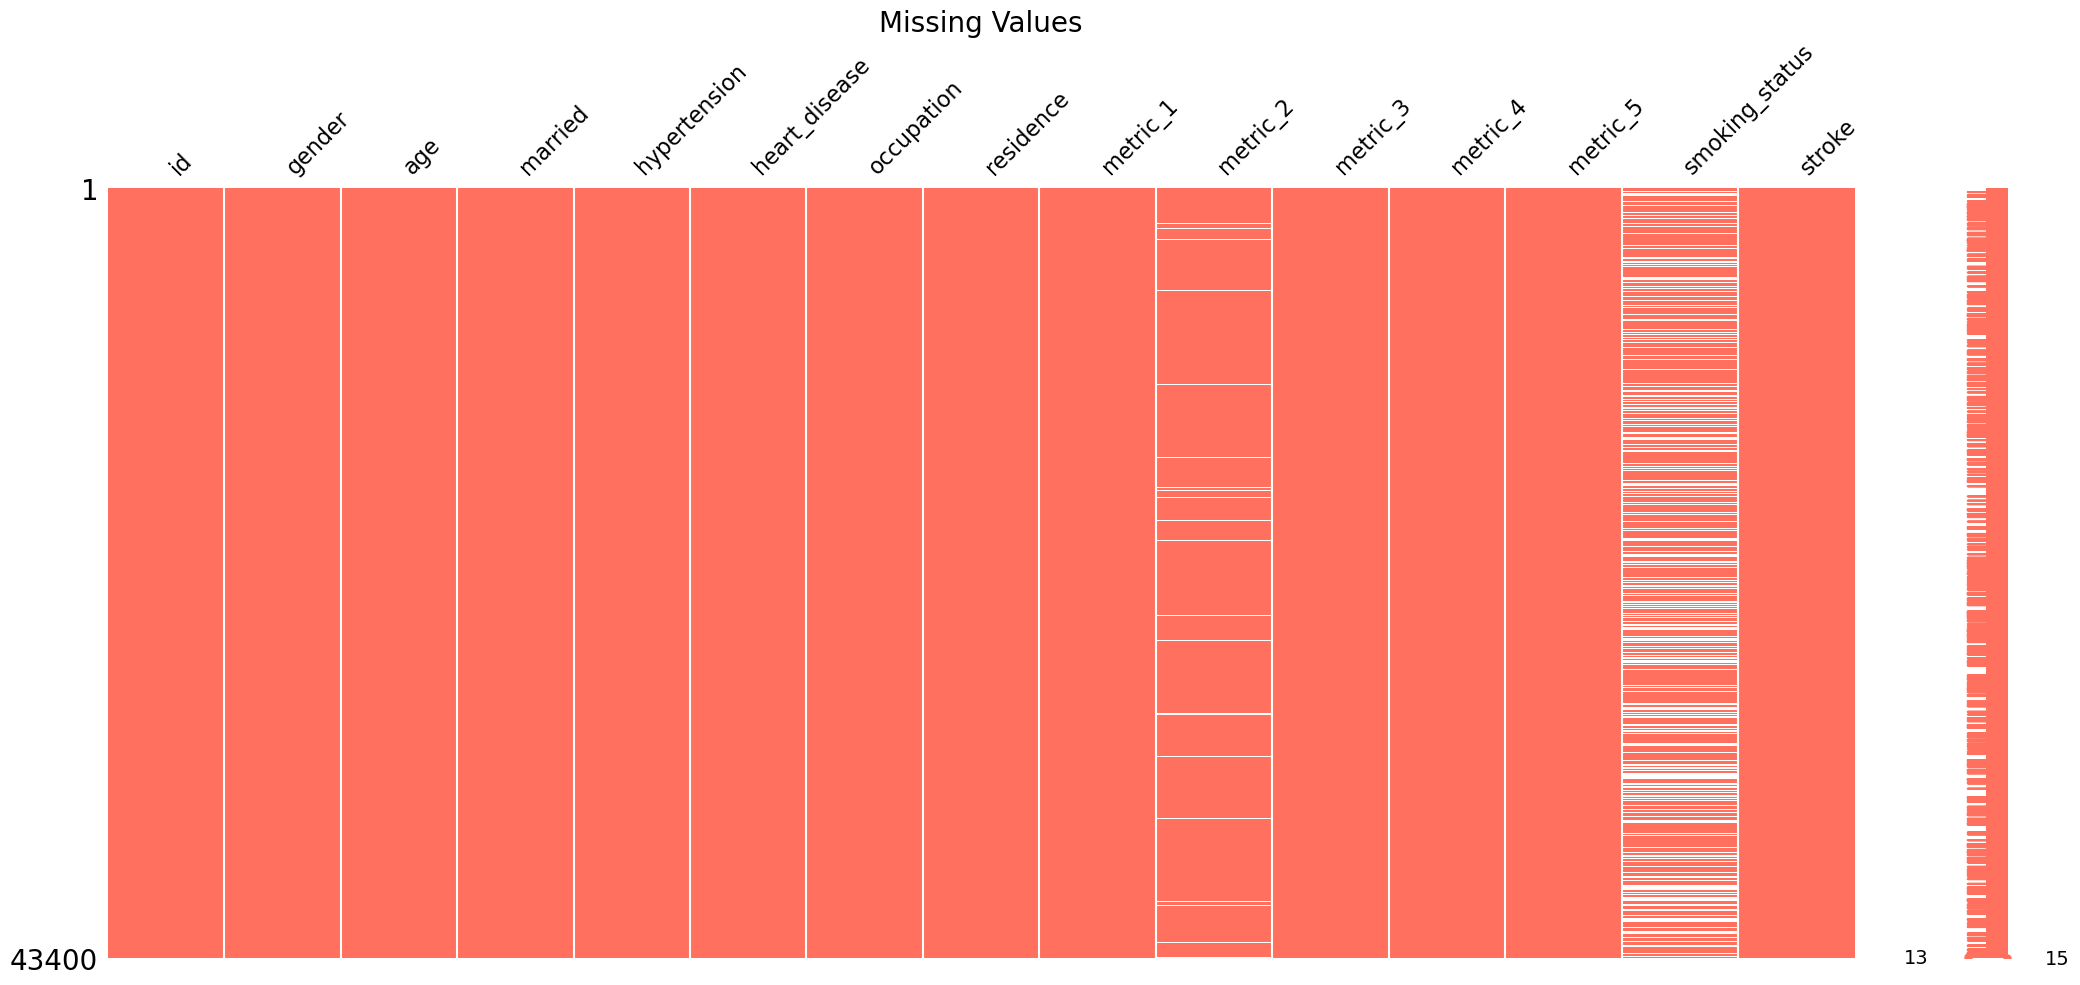

In [7]:
# Gives positional information of the missing values
msno.matrix(df, color=(1.0, 0.44, 0.37))
#{lightsalmonpink}{rgb}{1.0, 0.6, 0.6}
#{bittersweet}{rgb}{1.0, 0.44, 0.37}
plt.title("Missing Values", fontsize=20)
plt.show()

In [8]:
## check the missing value for each variable
def missing_df(df):  
    miss_cnt = []
    miss_perc = []
    for i in df.columns:
        # count number of rows with missing values
        n_miss = df[[i]].isnull().sum()[0]
        miss_cnt.append(n_miss)
        miss_perc.append(n_miss * 100 / len(df[[i]]))
        #print(i, ': Missing: %d (%.1f%%)' % (n_miss, perc))

    miss_val = pd.DataFrame({'features': df.columns, 'missing_val': miss_cnt, 'missing_percentage':miss_perc})
    miss_val.sort_values(by = 'missing_val', ascending=False, inplace=True)
    return miss_val

def plot_missing_pct(missing_df):
    missing_df.index = missing_df.col_name
    missing_df[['missing_percentage']].plot(kind = 'bar',figsize = (14, 3), title = 'Missing percentage')

In [9]:
missing_df(df)

,features,missing_val,missing_percentage
13,smoking_status,13292,30.626728
9,metric_2,1462,3.368664
0,id,0,0.000000
1,gender,0,0.000000
2,age,0,0.000000
3,married,0,0.000000
4,hypertension,0,0.000000
5,heart_disease,0,0.000000
6,occupation,0,0.000000
7,residence,0,0.000000


>**Observations:** 
1. `smoking_status` has ~30% of missing value
2. `metric_2` has 3% of missing value

Will check with these missing value later and see how to impute the missing value

### Categorical features

In [10]:
#categorical features
catfeatures =[]
for col in df.columns:
    if df[col].dtype == 'O':
        catfeatures.append(col)
cat_df = df[catfeatures]

for cat in cat_df.columns:
    print(f'{cat}:')
    print(f'there are {cat_df[cat].nunique()} unique values')
    print(f'{cat_df[cat].unique()[:10]}')
    print(df.groupby(cat)['id'].count())
    print('\n')

gender:
there are 3 unique values
['Male' 'Female' 'Other']
gender
Female    25665
Male      17724
Other        11
Name: id, dtype: int64


married:
there are 2 unique values
['No' 'Yes']
married
No     15462
Yes    27938
Name: id, dtype: int64


occupation:
there are 5 unique values
['A' 'B' 'C' 'D' 'E']
occupation
A     6156
B    24834
C      177
D     6793
E     5440
Name: id, dtype: int64


residence:
there are 2 unique values
['Rural' 'Urban']
residence
Rural    21644
Urban    21756
Name: id, dtype: int64


smoking_status:
there are 3 unique values
[nan 'never smoked' 'formerly smoked' 'smokes']
smoking_status
formerly smoked     7493
never smoked       16053
smokes              6562
Name: id, dtype: int64




>**Observations:** 
1. `gender`: the majority (99%) of the dataset are showing biological sexes: female and male. `Other` might be transgender or bisexal individuals. But due to lack of infomation, I will assume the `gender` means tranditional definition of gender, only includes male and female. I will drop the 11 `Other` rows.
2. `smoking_status`: I might fill.nan with 'Unknown'

Overall, no typos in catergorical features

### Numeric features

In [11]:
numfeatures =[]
for col in df.columns:
    if df[col].dtype != 'O':
        numfeatures.append(col)
numfeatures.remove('id')
cat_df = df[numfeatures]

for num in numfeatures:
    print(f'{num} min:{df[num].min()} max:{df[num].max()} number of unique values {df[num].nunique()}')
    print("\n")

age min:-10.0 max:1000.0 number of unique values 107


hypertension min:0 max:1 number of unique values 2


heart_disease min:0 max:1 number of unique values 2


metric_1 min:55.0 max:291.05 number of unique values 12543


metric_2 min:10.1 max:97.6 number of unique values 555


metric_3 min:0 max:1 number of unique values 2


metric_4 min:87.42 max:100.0 number of unique values 842


metric_5 min:55.0 max:291.05 number of unique values 12543


stroke min:0 max:1 number of unique values 2




## Summary Plan:

1. Check outliers of `age`
2. Drop `metirc-5` due to redundancy
3. Drop `id` due to no impact on target
4. Fill `smoking_status` with 'Unknow'
5. Fill `metric_2` with mean or median depending on the distribution
6. Drop `Other` rows (11 rows) in `gender`

<a id='eda'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">EDA</h1>

## Graphing Functions

In [12]:
def set_spine(ax):
    spine_names = ('top', 'right')
    for spine_name in spine_names:
        ax.spines[spine_name].set_visible(False)

In [13]:
def make_chart_cat(df, col, target):
    print(f'Missing value: {df[col].isnull().sum()}')
    print(f'{col} Unique Values:{df[col].unique()}')
    
    #make cross table
    cross_tab_prop = pd.crosstab(index=df_mod[col], columns=df_mod[target], normalize="index")
    print(cross_tab_prop)
    cross_tab = pd.crosstab(index=df_mod[col], columns=df_mod[target])
    
    plt.figure(figsize = (12,10), dpi = 100)
    
    #graph 1
    plt.subplot(221)
    df_mod[col].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colormap='Set3')
    plt.title(f'{col} Value Percentage')
    plt.ylabel(None)
    
    #graph 2
    ax = plt.subplot(222)
    cross_tab.plot(kind='bar', 
                    color=['skyblue','salmon'], ax = ax)
    ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5), title=target, \
              fancybox=True, labels=['No', 'Yes'])
    plt.title(f'Frequency of {target} among Different {col}')
    ax.tick_params(axis='x', rotation='auto')
    set_spine(ax)
    
    #graph 3
    ax = plt.subplot(223)
    cross_tab_prop.plot(kind='bar', stacked=True, color=['skyblue','salmon'], ax = ax)
    ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5), title=target, \
              fancybox=True, labels=['No', 'Yes'])
    plt.title(f'Proportion of {target} among Different {col}')
    ax.tick_params(axis='x', rotation='auto')
    set_spine(ax)
    
    plt.tight_layout()
    plt.show()

In [14]:
def make_chart_num(df, col, target, binswith = 10):
    
    print(f"Number of unique value in {col}: {df[col].nunique()}")
    print(f"Missing values: {df[col].isnull().sum()}")
    print(f"The range of value is between {df[col].min()} and {df[col].max()}.")
    print(f"The median value is {df[col].median()}")
    
    plt.figure(figsize = (12,10), dpi = 100)
    
    #graph 1 - histogram with percentage
    ax = plt.subplot(221)
    ax.hist(df[col], color = 'skyblue', bins=range(int(min((df[col]))), int(max(df[col])) + binswith, binswith))
    set_spine(ax)
    plt.title(f'Distribution of {col}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel(f'Count')
    #calculate percentage
    for rect in ax.patches:
        height = rect.get_height()
        percent = (height/len(df[col]))*100
        ax.annotate(f'{percent:.2f}%', xy=(rect.get_x()+rect.get_width()/2, height), 
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
    
    #graph 2 - boxplot
    ax = plt.subplot(222)
    sns.boxplot(x=target,y=col, data=df, palette = ['skyblue', 'salmon'] )
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    
    #graph 3 - histogram
    #https://math.stackexchange.com/questions/2666834/what-is-the-difference-between-frequency-and-density-in-a-histogram
    # each bin will display the bin's raw count divided by the total number of counts and the bin width
    ax = plt.subplot(223)
    df_mod[df_mod[target]==1][col].plot(kind = 'hist', density=True, ax=ax,\
                                          color = 'salmon', alpha = 0.6, label = 'Yes')
    df_mod[df_mod[target]==0][col].plot(kind = 'hist', density=True, ax=ax,\
                                              color = 'skyblue', alpha = 0.8, label = 'No')
    plt.ylabel('Density')
    

    # set the legend in the upper right corner
    ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5), title=target, fancybox=True)

    # set title and labels
    ax.set_title(f'Distribution of Observations by {col}', fontsize=10, loc='center')
    ax.tick_params(rotation='auto')
    set_spine(ax)
    
    #graph 4
    ax = plt.subplot(224)
    df[col].plot.box(ax=ax)
    set_spine(ax)
    plt.title(f'{col} Distirbution')
    
    plt.tight_layout()
    plt.show()

In [15]:
def make_graph(df, target):
    for col in df.columns:
        print(f"Graph for {col}")
        if df[col].nunique() > 6:
            if df[col].max() - df[col].min() < 10:
                binswith = 1
            elif df[col].max() - df[col].min() < 80:
                binswith = 10
            else:
                binswith = 20
            make_chart_num(df, col, target, binswith = binswith)
        else:
            make_chart_cat(df, col, target)   

## Data Munging

> three members have abnormal age number will drop this rows

In [16]:
display(df[(df['age'] > 100) | (df['age'] < 0)])
#identify the index of abnomal age members
ab_age_index = df[(df['age'] > 100) | (df['age'] < 0)].index

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
6123,6124,Female,1000.0,Yes,1,1,B,Rural,74.38,30.0,1,97.75,74.38,formerly smoked,0
19352,19353,Male,-10.0,Yes,0,0,B,Rural,180.48,40.1,1,96.62,180.48,smokes,0
36604,36605,Female,999.0,No,0,0,A,Rural,58.24,17.6,0,96.14,58.24,NaN,0


In [17]:
# members younger than 2 years old have decimal age
df[(df['age'] < 2) & (df['age'] >= 0) ]['age'].unique()

array([0.64, 0.88, 1.8 , 0.32, 1.08, 1.16, 1.  , 1.4 , 1.72, 0.24, 1.64,
       1.56, 0.72, 1.88, 1.24, 0.8 , 0.4 , 0.08, 1.48, 0.56, 0.48, 1.32,
       0.16])

In [18]:
df[(df['age'] >= 2) ]['age'].unique()

array([   3.,   58.,    8.,   70.,   14.,   47.,   52.,   75.,   32.,
         74.,   79.,   37.,   40.,   35.,   20.,   42.,   44.,   65.,
         57.,   49.,   71.,   59.,   25.,   67.,   38.,   54.,   27.,
         23.,   55.,   17.,   13.,    4.,   16.,   22.,   45.,   66.,
         69.,   53.,   78.,   43.,   51.,   30.,   46.,   61.,   48.,
         29.,   11.,   76.,   21.,   18.,   33.,   82.,   24.,   34.,
         64.,   68.,   60.,   36.,   39.,   72.,   41.,   56.,    5.,
         80.,   26.,   31.,    7.,   12.,   63.,   62.,    2.,   81.,
          9.,   15.,   28.,   10.,   77.,   73.,   50.,   19.,    6.,
       1000.,  999.])

In [19]:
display(df[df['gender'] == 'Other'])
#identify the index of gender belongs to 'other'
other_gender_index = df[df['gender'] == 'Other'].index

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
2914,2915,Other,26.0,No,0,0,B,Rural,143.33,22.4,0,94.92,143.33,formerly smoked,0
10768,10769,Other,46.0,No,0,0,B,Rural,83.28,NaN,1,98.31,83.28,never smoked,0
15620,15621,Other,27.0,No,0,0,B,Urban,62.45,NaN,0,99.44,62.45,smokes,0
15838,15839,Other,53.0,Yes,0,0,B,Rural,89.65,NaN,0,94.48,89.65,NaN,0
19748,19749,Other,39.0,Yes,0,0,E,Urban,95.59,32.0,1,97.85,95.59,formerly smoked,0
21041,21042,Other,19.0,No,0,0,B,Rural,75.76,32.2,0,98.95,75.76,formerly smoked,0
21192,21193,Other,49.0,Yes,0,0,B,Urban,94.88,37.2,1,97.86,94.88,never smoked,0
24252,24253,Other,51.0,Yes,0,0,B,Rural,91.75,32.2,0,95.28,91.75,formerly smoked,0
26199,26200,Other,10.0,No,0,0,A,Rural,72.05,21.2,1,97.89,72.05,formerly smoked,0
26831,26832,Other,53.0,Yes,0,0,E,Urban,65.29,NaN,0,97.50,65.29,NaN,0


## Clean dataframe -- df_mod

In [20]:
##copy dataframe from original
df_mod = df.copy()
##code to remove outliers
df_mod.drop(ab_age_index, inplace = True)
df_mod.drop(other_gender_index, inplace = True)

#reset_index after dropping
df_mod = df_mod.reset_index(drop=True)

# drop duplicate column - metric_5
df_mod = df_mod.drop(columns = ['id', 'metric_5'])
display(df_mod)
print(df_mod.shape)

,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,smoking_status,stroke
0,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,NaN,0
1,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,never smoked,0
2,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,NaN,0
3,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,formerly smoked,0
4,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43381,Female,10.0,No,0,0,A,Urban,58.64,20.4,0,97.23,never smoked,0
43382,Female,56.0,Yes,0,0,E,Urban,213.61,55.4,0,97.81,formerly smoked,0
43383,Female,82.0,Yes,1,0,B,Urban,91.94,28.9,0,95.35,formerly smoked,0
43384,Male,40.0,Yes,0,0,B,Urban,99.16,33.2,0,96.40,never smoked,0


(43386, 13)


In [21]:
outliers = ab_age_index.to_list() + other_gender_index.to_list()

In [22]:
#encode NaN in smoking_status as Unknown
df_mod['smoking_status'] = df_mod['smoking_status'].fillna('Unknown')

In [23]:
#occupation A is for youth
print(df_mod[df_mod['occupation'] == 'A']['age'].max())
print(df_mod[df_mod['occupation'] == 'A']['age'].min())
print(df_mod[df_mod['occupation'] == 'A']['age'].mean())

16.0
0.08
6.6981309930115716


In [24]:
#make sure the married data is reasonable
df_mod[df_mod['married'] == 'Yes']['age'].min()

17.0

## Univariate analysis

### Target - stroke

> Highly imbalance dataset with less than 2% positive samples. Deal with imbalance data with options
1. oversampling (repetitive or SMOTE, ADASYN)
2. undersampling (lose information, NeighbourhoodCleaningRule)
3. add weight to loss function
4. use precision/recall instead of accuracy
5. use more imbalance data robust model: tree-based model
6. ensemble method (EasyEnsembleClassifier, BalancedBaggingClassifier)
7. combination of the above technique

Stroke rate of member is: 1.80% 


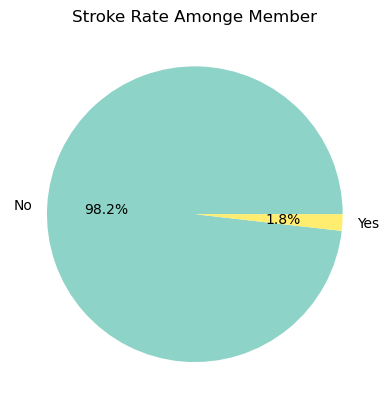

In [25]:
# proportion of observation of each class
stroke_rate = df_mod['stroke'].value_counts(normalize=True)
print(f'Stroke rate of member is: {stroke_rate[1] *100:.2f}% ')
# create a bar plot showing the percentage of churn
df_mod['stroke'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colormap='Set3', labels=['No', 'Yes'])
plt.title(f'Stroke Rate Amonge Member')
plt.ylabel(None)
plt.show()

### individual features

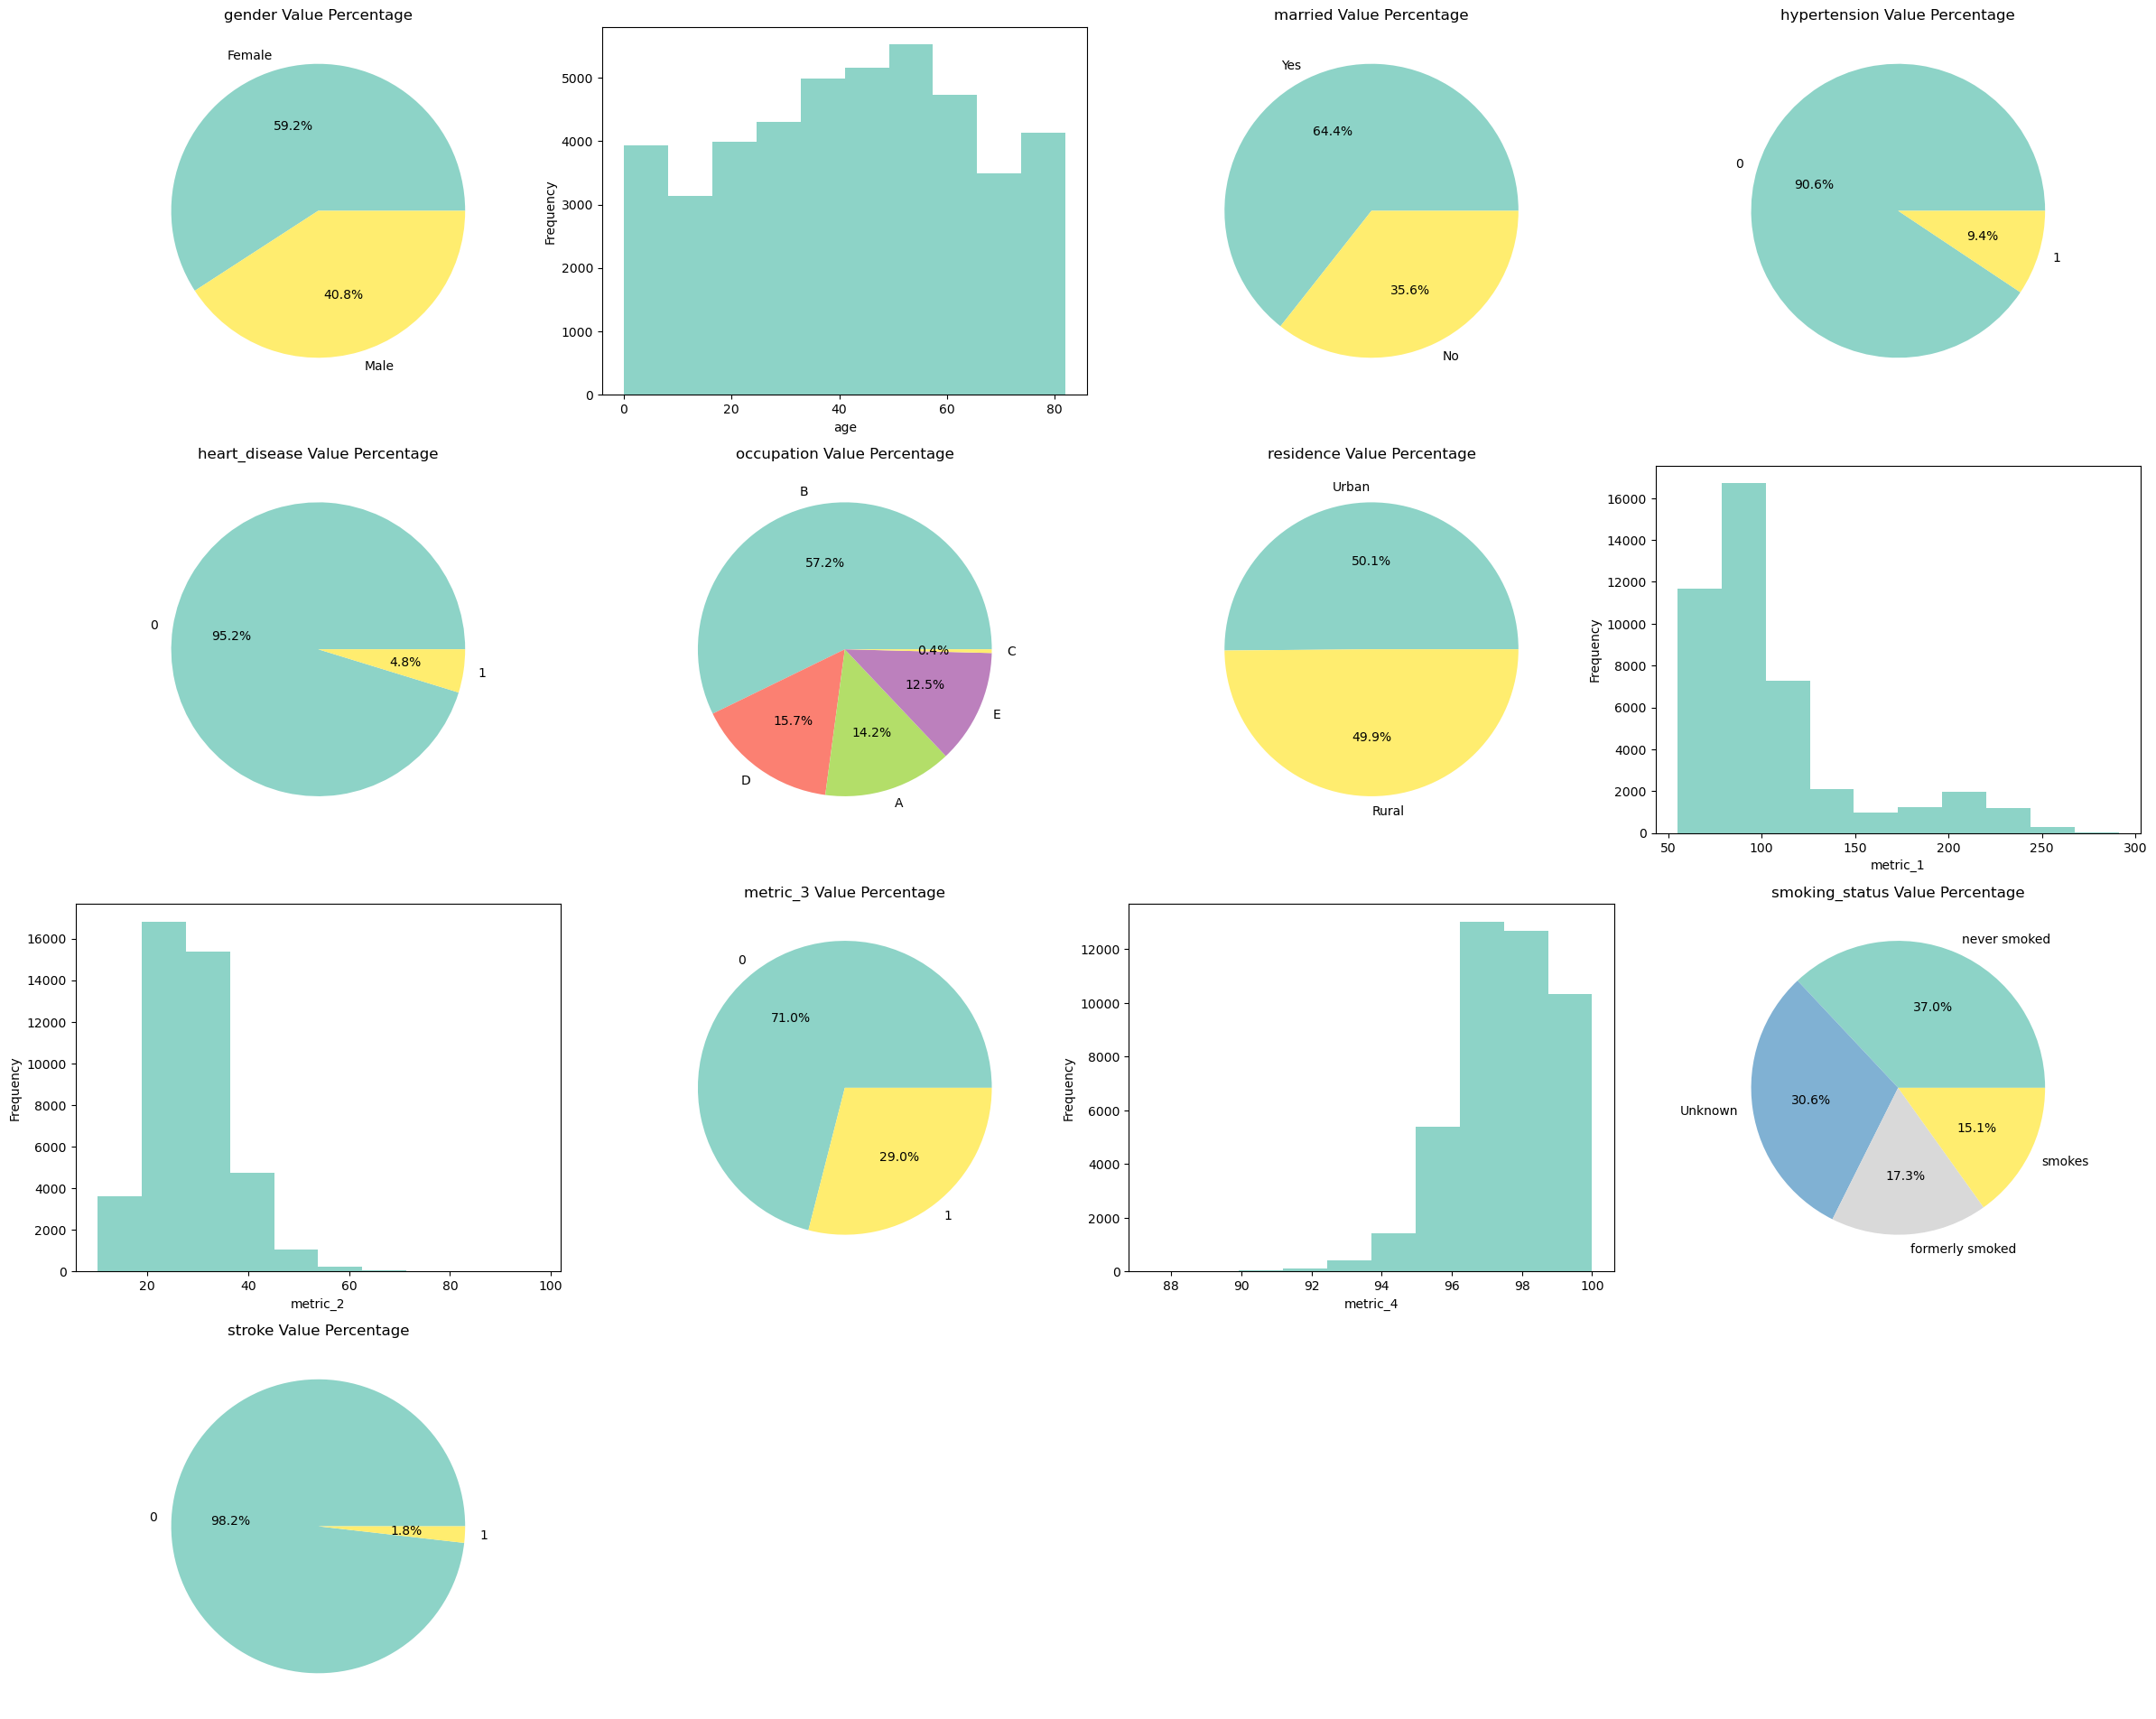

In [26]:
def univariate_chart(df):
    fig = plt.figure(figsize = (24, 24))
    i = 0
    for col in df:
        sub = fig.add_subplot(5, 4, i + 1)
        
        if df[col].nunique() > 5:
            sub.set_xlabel(col)
            df[col].plot(kind = 'hist', colormap='Set3')
        else:
            df[col].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colormap='Set3')
            plt.title(f'{col} Value Percentage')
            plt.ylabel(None)
        i += 1
    plt.tight_layout()
    plt.show()
    
univariate_chart(df_mod)

In [27]:
df_mod['metric_2'].skew()
#value > 0 tail is larger towards the right side of the distribution

0.8989397679275966

> **Observation:**
1. `metric_2` right-skew, NaN can be filled using median
2. `residence` equally distribution between urban and rural
3. ~20% more woman than man members (ratio: male:female -> 40:60)

### Bivariate analysis

Graph for gender
Missing value: 0
gender Unique Values:['Male' 'Female']
stroke         0         1
gender                    
Female  0.983205  0.016795
Male    0.980139  0.019861


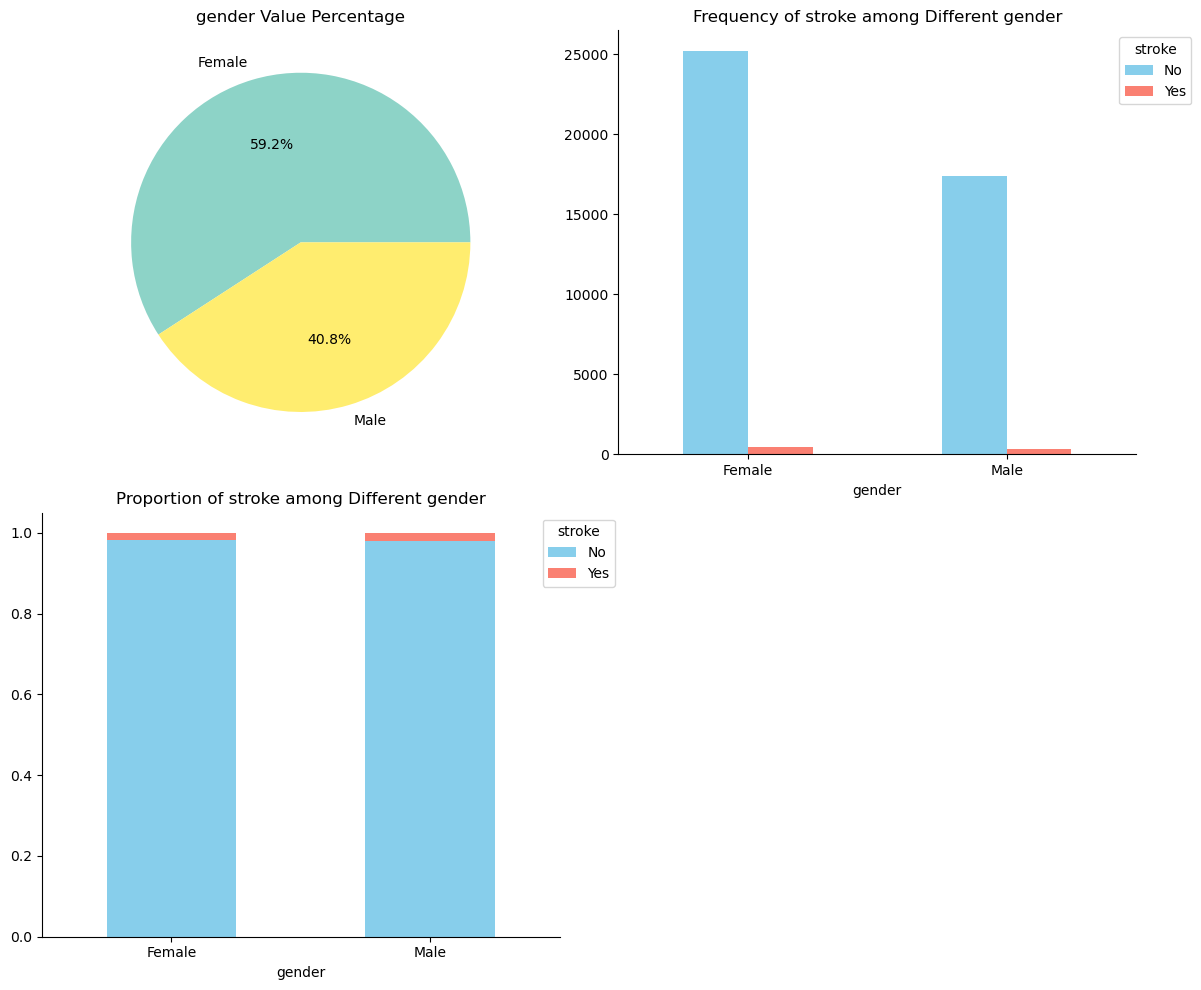

Graph for age
Number of unique value in age: 104
Missing values: 0
The range of value is between 0.08 and 82.0.
The median value is 44.0


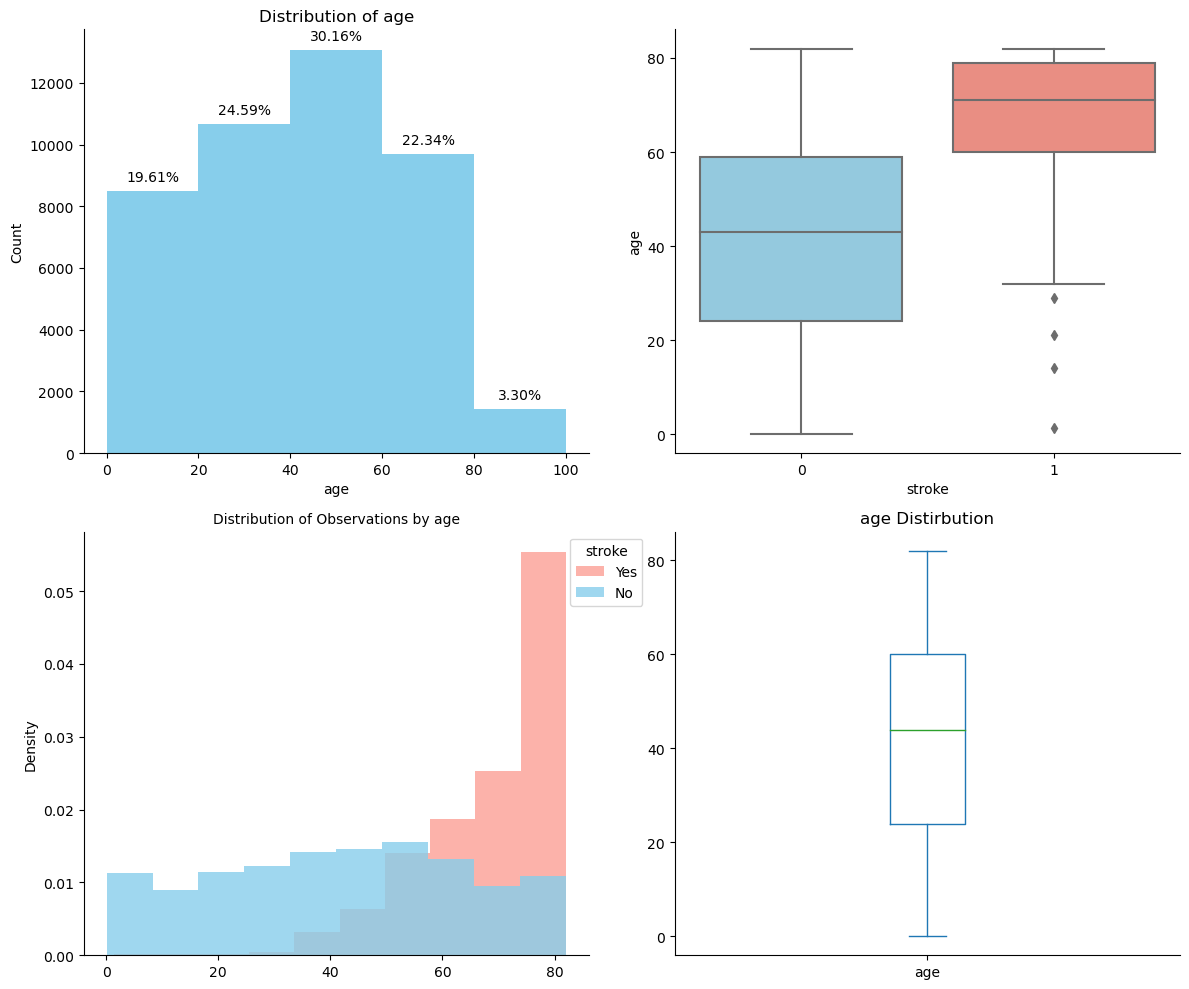

Graph for married
Missing value: 0
married Unique Values:['No' 'Yes']
stroke          0         1
married                    
No       0.994824  0.005176
Yes      0.974831  0.025169


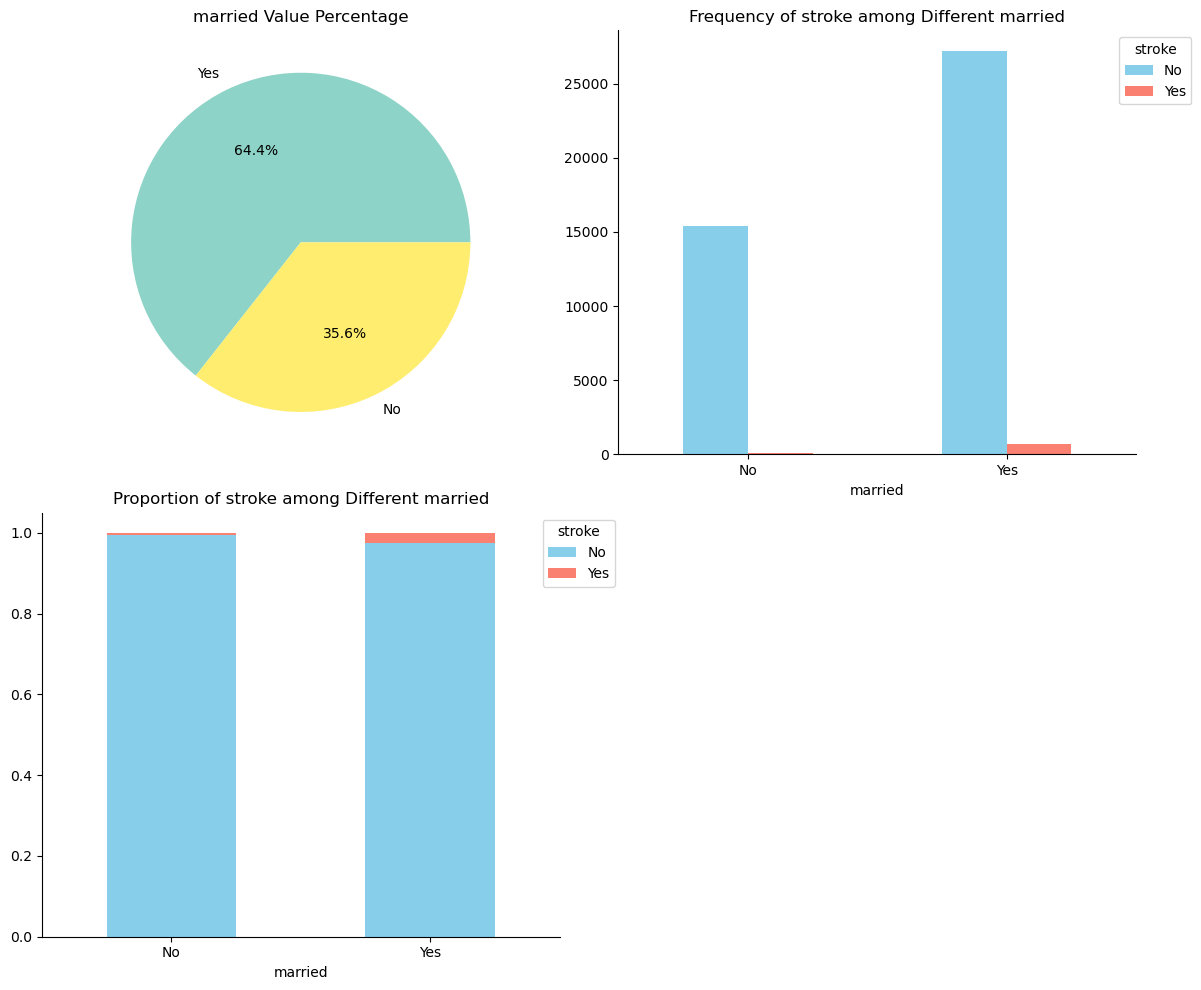

Graph for hypertension
Missing value: 0
hypertension Unique Values:[0 1]
stroke               0         1
hypertension                    
0             0.985175  0.014825
1             0.950739  0.049261


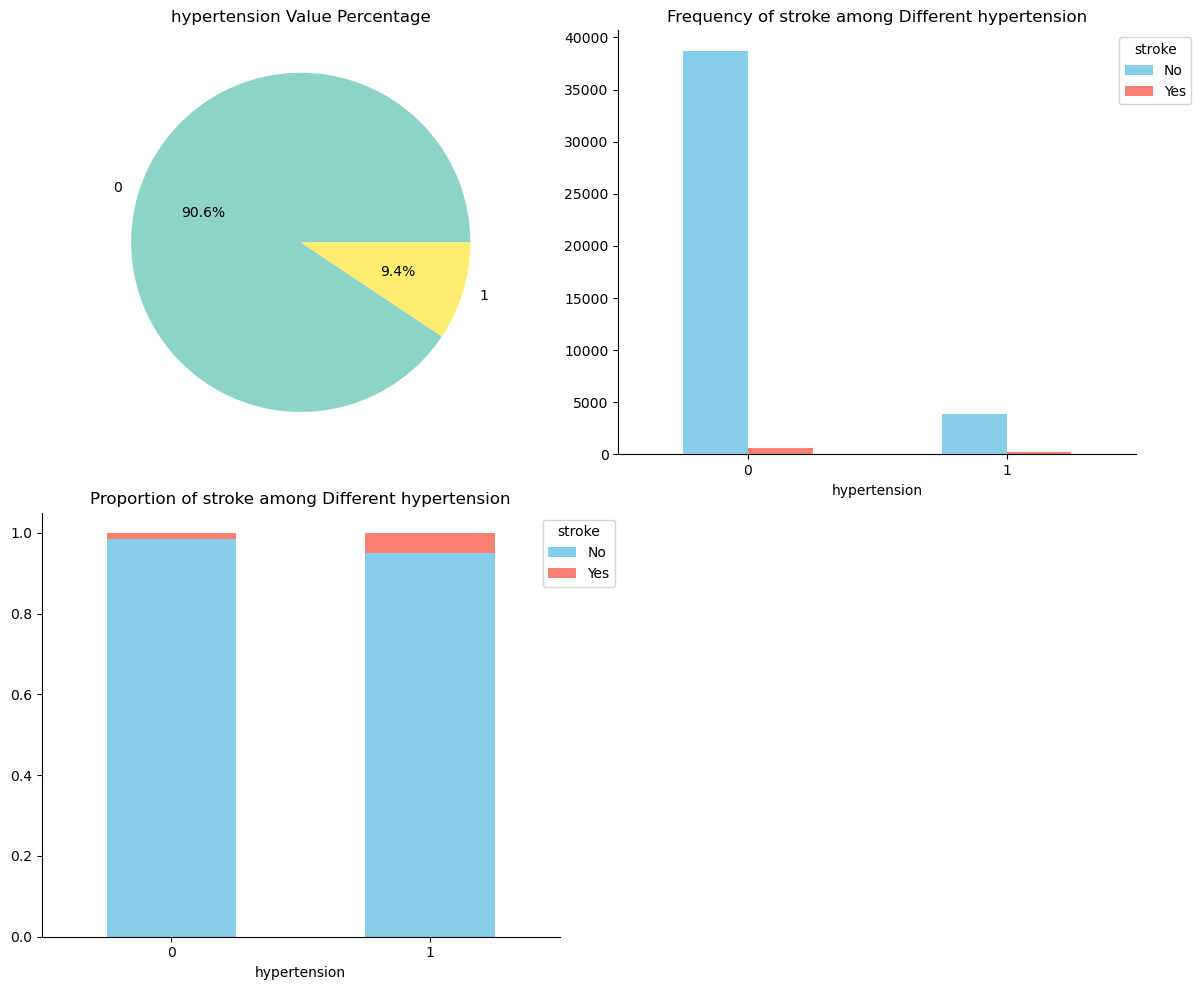

Graph for heart_disease
Missing value: 0
heart_disease Unique Values:[0 1]
stroke                0         1
heart_disease                    
0              0.985336  0.014664
1              0.914119  0.085881


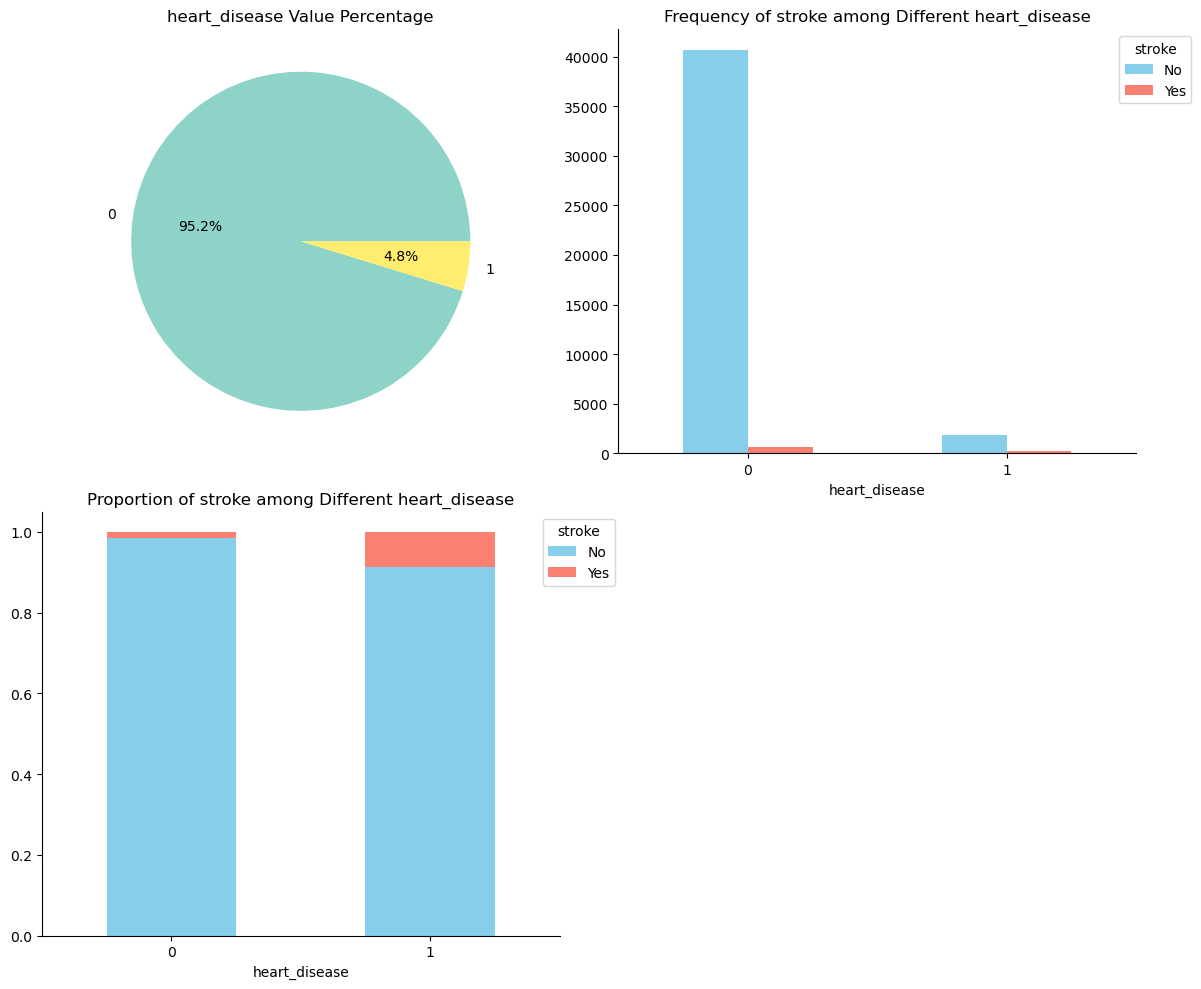

Graph for occupation
Missing value: 0
occupation Unique Values:['A' 'B' 'C' 'D' 'E']
stroke             0         1
occupation                    
A           0.999675  0.000325
B           0.982236  0.017764
C           1.000000  0.000000
D           0.963050  0.036950
E           0.983634  0.016366


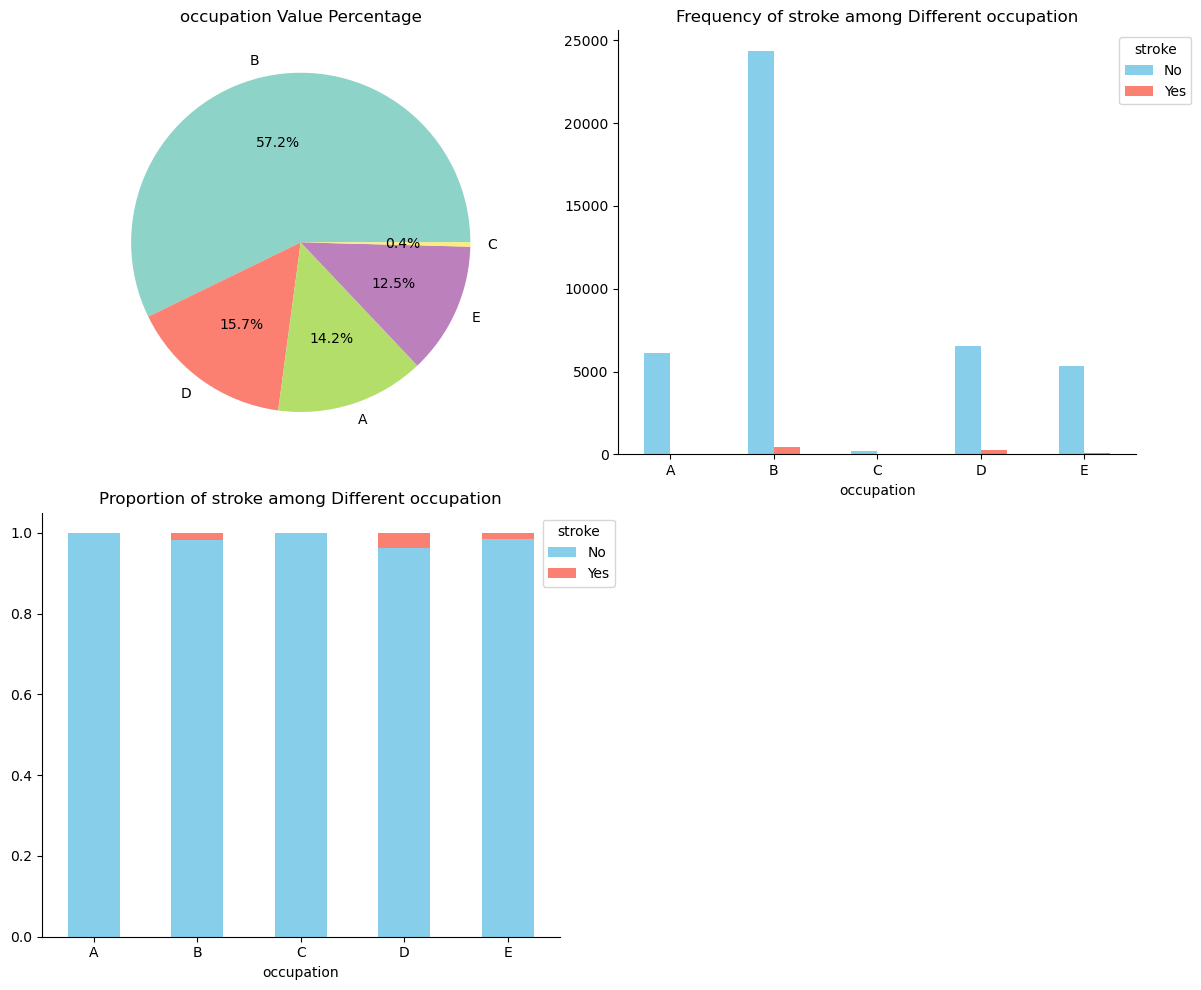

Graph for residence
Missing value: 0
residence Unique Values:['Rural' 'Urban']
stroke            0         1
residence                    
Rural      0.982251  0.017749
Urban      0.981656  0.018344


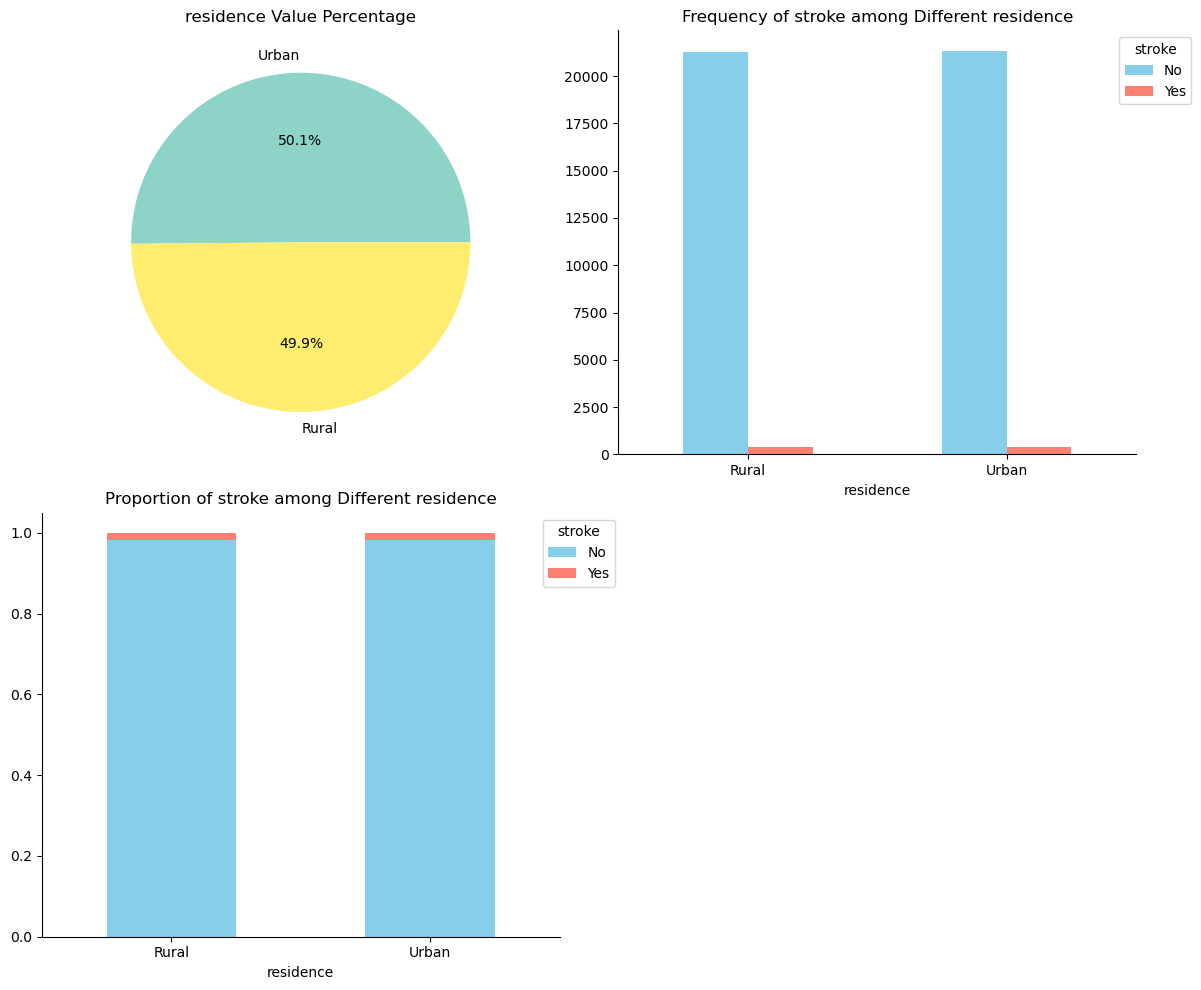

Graph for metric_1
Number of unique value in metric_1: 12543
Missing values: 0
The range of value is between 55.0 and 291.05.
The median value is 91.58


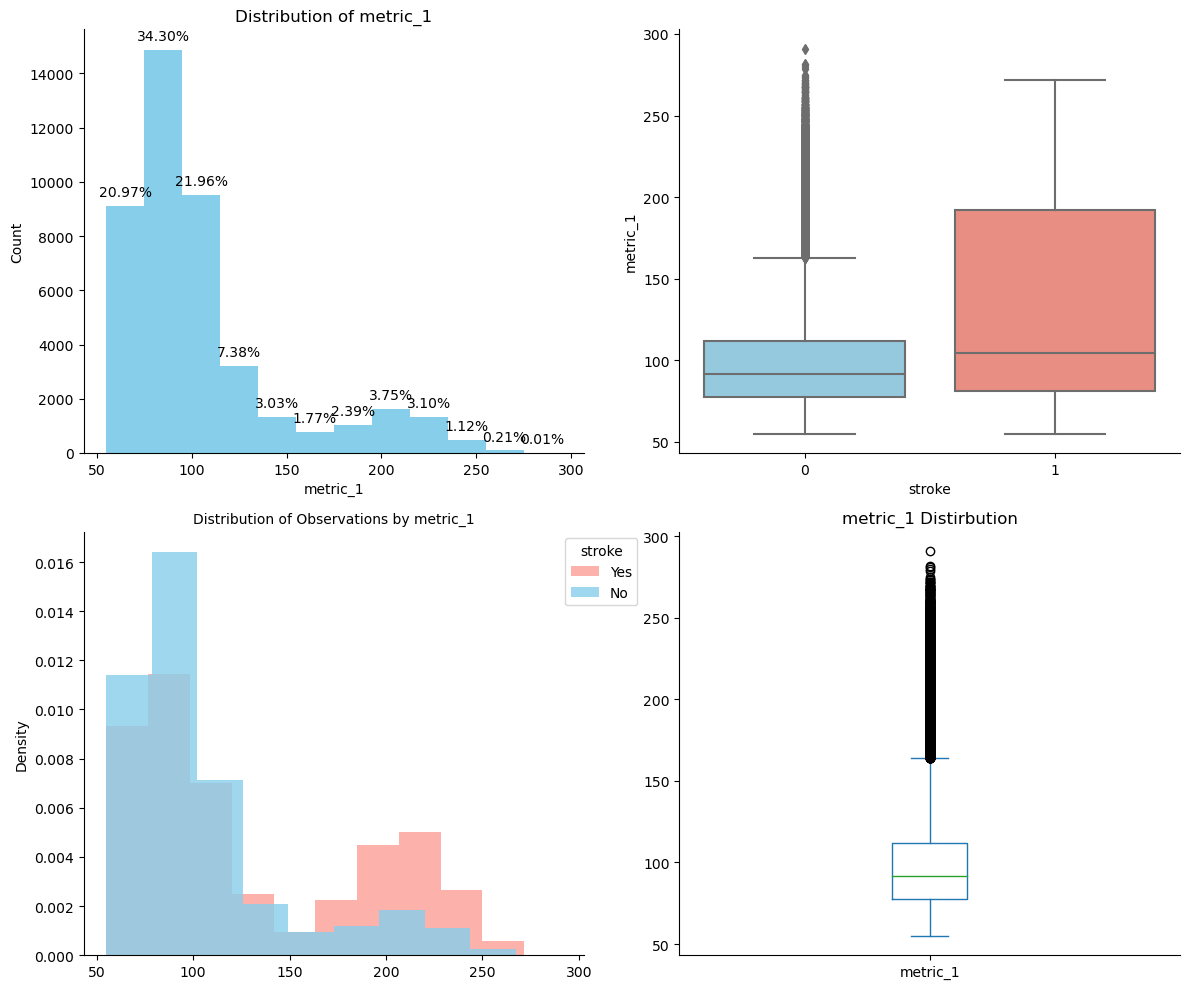

Graph for metric_2
Number of unique value in metric_2: 555
Missing values: 1458
The range of value is between 10.1 and 97.6.
The median value is 27.7


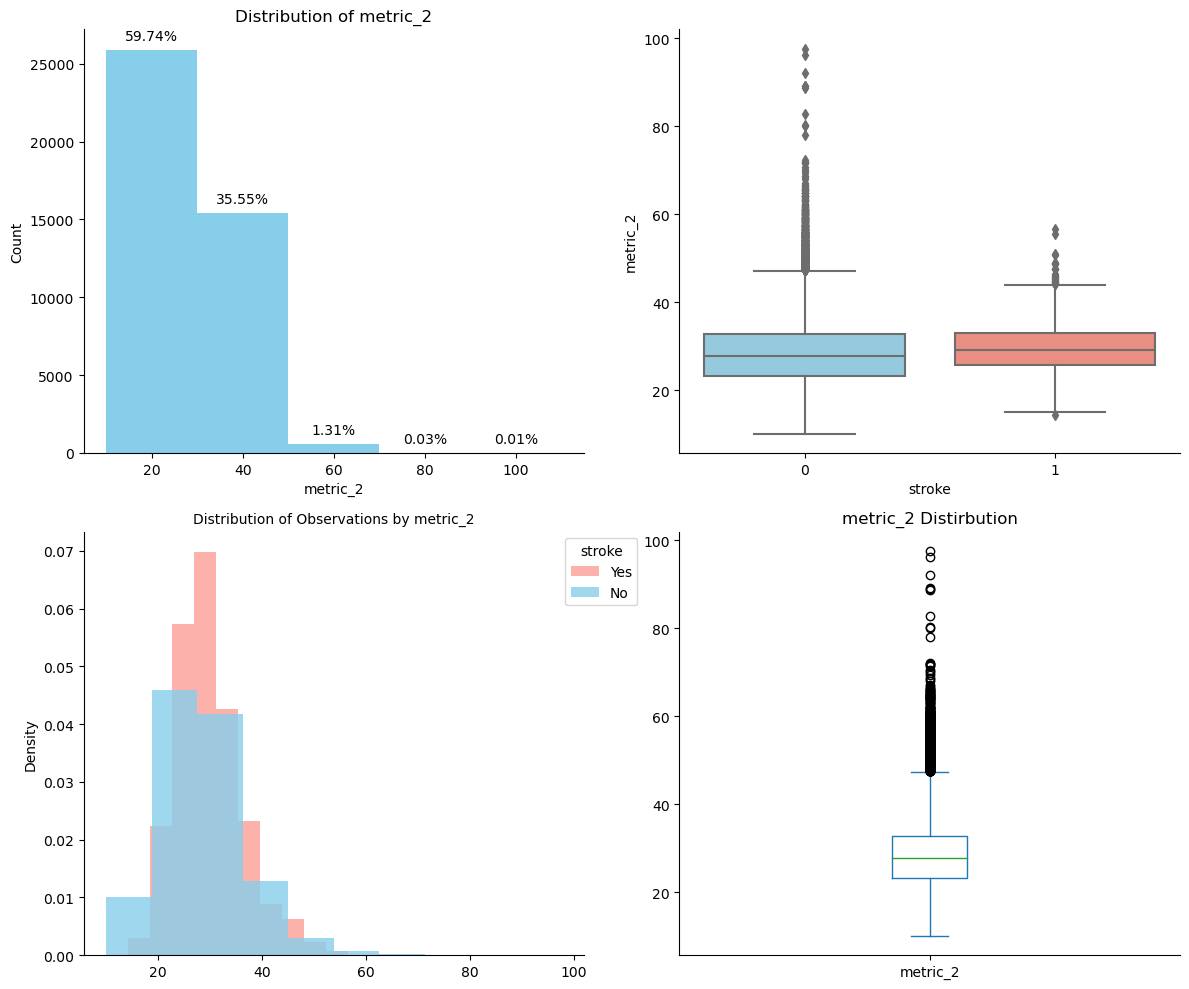

Graph for metric_3
Missing value: 0
metric_3 Unique Values:[1 0]
stroke           0         1
metric_3                    
0         0.981662  0.018338
1         0.982665  0.017335


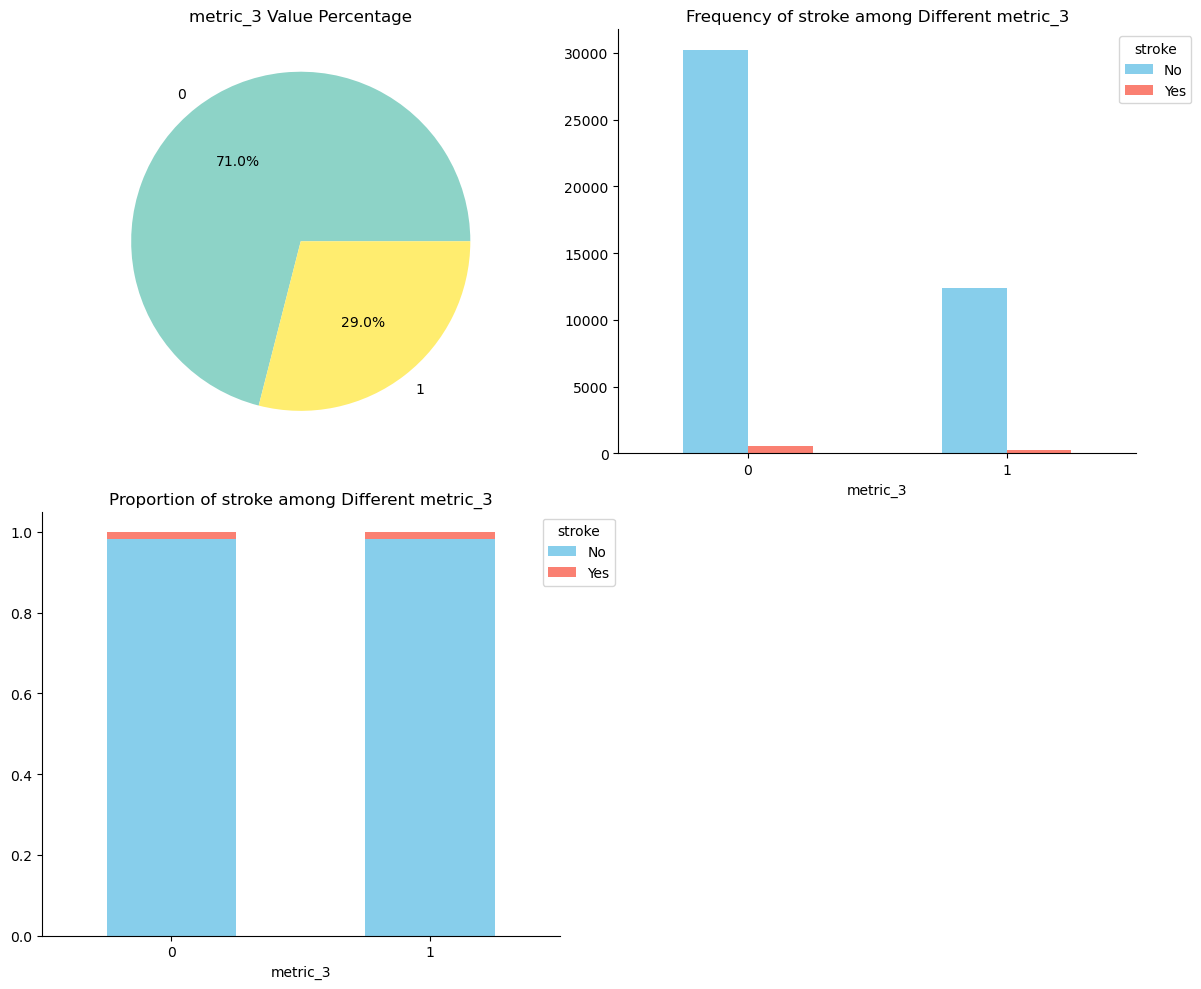

Graph for metric_4
Number of unique value in metric_4: 842
Missing values: 0
The range of value is between 87.42 and 100.0.
The median value is 97.61


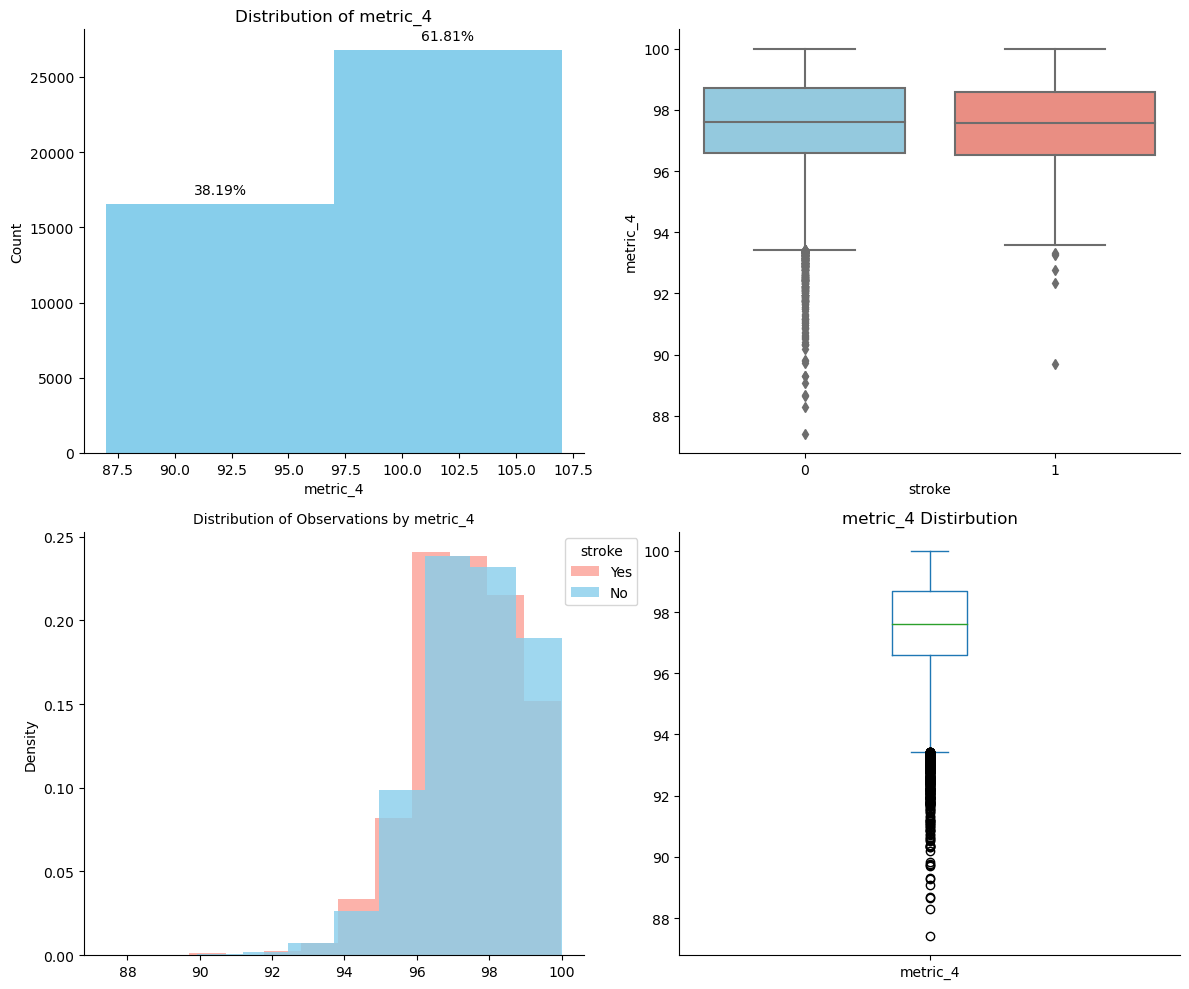

Graph for smoking_status
Missing value: 0
smoking_status Unique Values:['Unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke                  0         1
smoking_status                     
Unknown          0.989089  0.010911
formerly smoked  0.970478  0.029522
never smoked     0.982306  0.017694
smokes           0.979726  0.020274


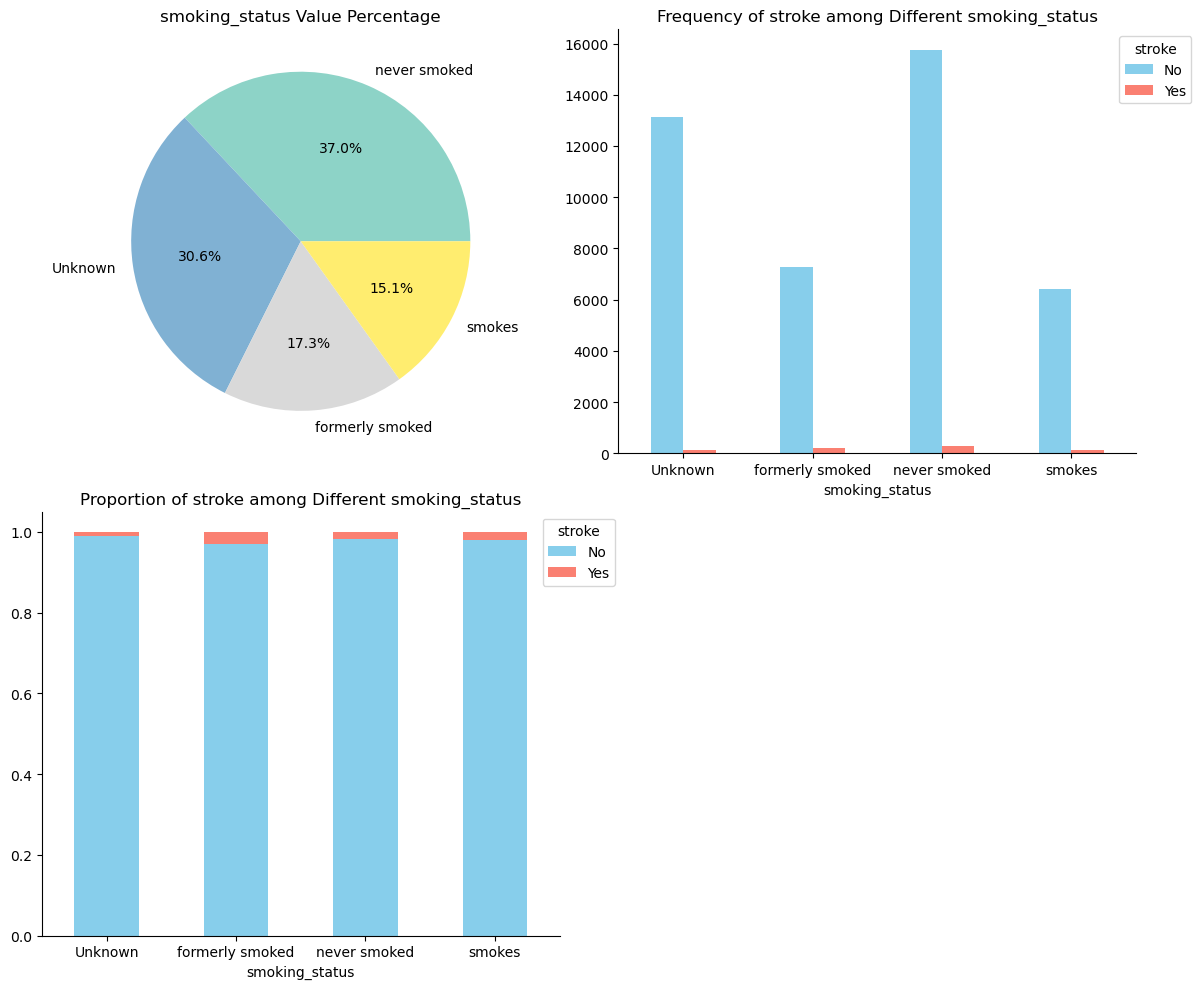

Graph for stroke
Missing value: 0
stroke Unique Values:[0 1]
stroke    0    1
stroke          
0       1.0  0.0
1       0.0  1.0


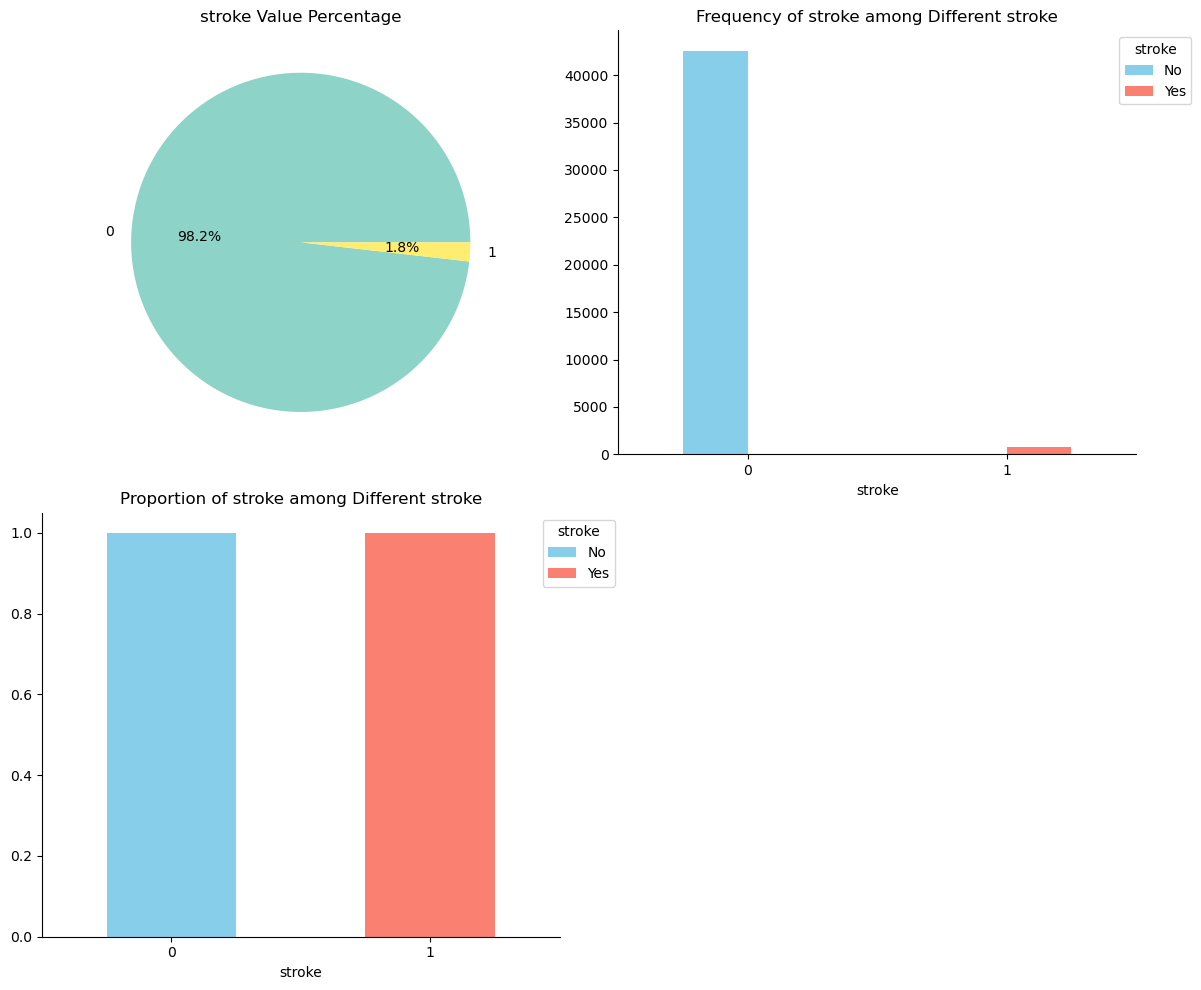

In [28]:
make_graph(df_mod, 'stroke')

In [29]:
#age < 30 and got stroke canbe consider outliers
display(df_mod[(df_mod['age']<30) & (df_mod['stroke']==1)])
print(len(df_mod[df_mod['age']<30]))

,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,smoking_status,stroke
9959,Female,1.32,No,0,0,A,Urban,70.37,NaN,0,96.82,Unknown,1
14799,Female,14.00,No,0,0,A,Rural,57.93,30.9,0,94.53,Unknown,1
15661,Male,21.00,No,0,0,B,Rural,67.42,25.7,1,96.30,never smoked,1
36223,Male,29.00,Yes,0,0,B,Rural,60.72,NaN,1,98.88,formerly smoked,1


13705


> Note: Tried modeling with data `age > 30`, the model does not performed better than all age data.

Stroke rate of member is: 2.67% 


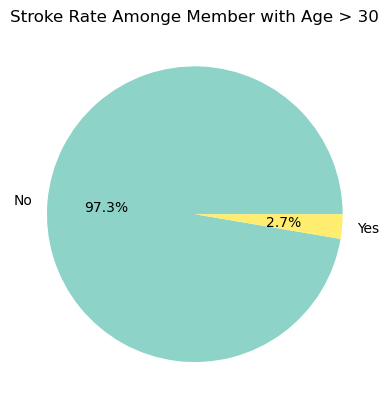

In [111]:
#df_older for age > 30
df_older = df_mod[df_mod['age']>30]
df_older.shape

stroke_rate = df_older['stroke'].value_counts(normalize=True)
print(f'Stroke rate of member is: {stroke_rate[1] *100:.2f}% ')
# create a bar plot showing the percentage of churn
df_older['stroke'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colormap='Set3', labels=['No', 'Yes'])
plt.title(f'Stroke Rate Amonge Member with Age > 30')
plt.ylabel(None)
plt.show()

> **Observations**
1. Percentage of stroke are similar in male and female `gender`
2. Median `age` of stroke member are older than non-stroke member. Older members has a higher tendency of stroke. Only four members had stroke if younger than 30, but there are 13705 members below 30 years old. Indicate that `age` might be important in predicting stroke.
3. `Married` members have a slightly higher stroke rate. This might also associated with age (colinearity).
4. Members who had `hypertension` have a higher stroke rate. -> might be important in prediction 
5. Members who had `heart disease` have a much higher stroke rate. -> might be important in prediction
6. Members who had D `occupation` have a higher stroke rate than B and E, followed by A and C.
7. No obvious differences of stroke rate between urban `residence` and rural residence. Indicated lack of relevant. 
8. More stroke members have higher `metric_1` at around 160 - 250 compared to non-stroke members. -> might be important in prediction
9. Stroke members have slightly higher `metric_2` value.
10. No obvious difference of `metric_3` values in stroke and non-stroke members. 
11. No obvious difference of `metric_4` distribution of stroke and non-stroke members.
12. formerly smoker members has a higher stroke rate than never smoked and `smokes` followed by unknown.

### Multivariate analysis

#### Pearson correlation - correlation between numeric features

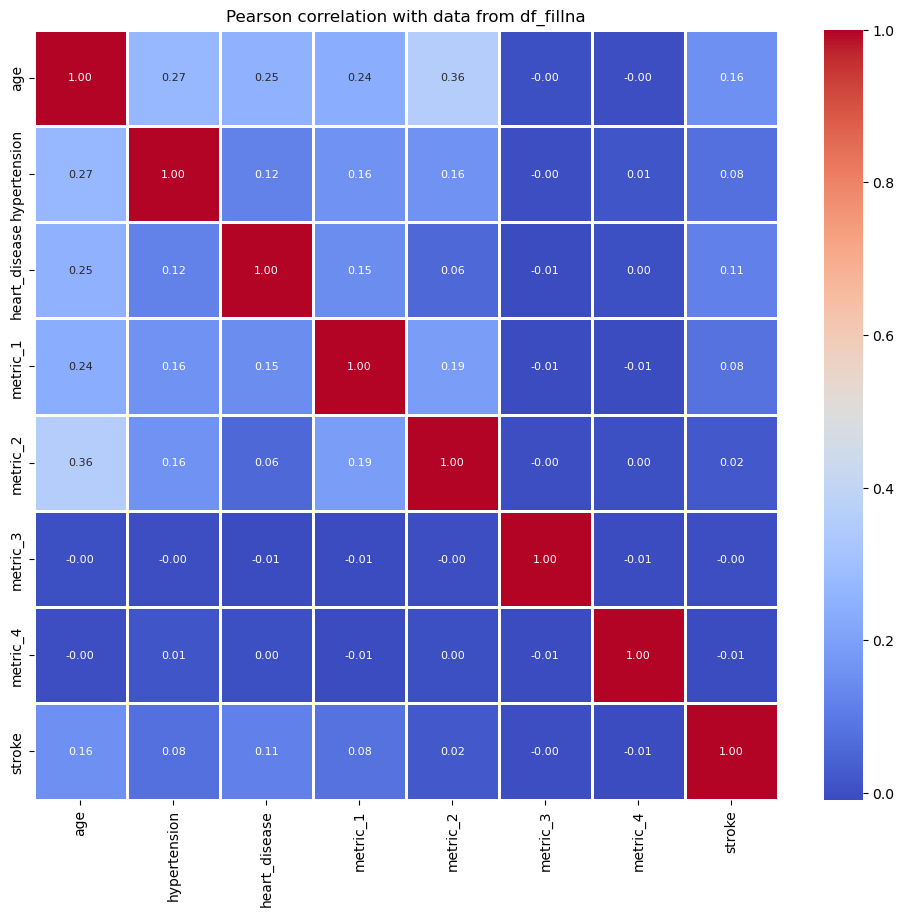

In [31]:
#remove metric_5 from numfeatures due to duplication
if 'metric_5' in numfeatures:
    numfeatures.remove('metric_5')

#pearson correlation in heatmap
plt.figure(figsize = (12,10), dpi = 100)
sns.heatmap(df_mod[numfeatures].corr(),\
           annot = True, fmt = ".2f", annot_kws = {"size": 8}, cmap = "coolwarm", linewidths = 1)
plt.title('Pearson correlation with data from df_fillna')
plt.show()

> No strong colinearity was observed between numeric features, but `Age` and `heart_disease` found to have higher correlation with `stroke`

#### Variance Inflation Factor (VIF) analysis

VIF score more than 10 are indicated multicolinearity. Sometimes can go conservative to be 6-5

In [32]:
# VIF dataframe
def check_vif(df):
    X = df.copy()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    vif_data = vif_data.sort_values(by=['VIF'], ascending = False)
    print(vif_data)
    return vif_data

def iterate_vif(df, threshold = 5):
    X = df.copy()
    a = None
    if not a:
        a = check_vif(X)
    vif_feature = []
    while True:
        maxi_vif = 0
        maxi_feature = None
        for i in range(len(a)):
            if a["VIF"][i] > maxi_vif:
                maxi_vif = a["VIF"][i]
                maxi_feature = a["Feature"][i]
                #print(maxi_vif,  maxi_feature)
        if maxi_vif > threshold:
            vif_feature.append(maxi_feature)
            X = X.drop(columns = [maxi_feature])
            a = check_vif(X)
            #print(a)
        else:
            break
    return vif_feature

In [33]:
#test for VIF multicolinearity
X = df_mod[numfeatures]
X = X.drop(columns = ['stroke'])
#fillna with median for metric_2
X = X.fillna(df.median())
vif_feature = iterate_vif(X, threshold = 5) #being conservative
print(vif_feature)

         Feature        VIF
6       metric_4  18.947441
4       metric_2  17.347771
3       metric_1   7.498190
0            age   5.864812
5       metric_3   1.407997
1   hypertension   1.209812
2  heart_disease   1.135298
         Feature       VIF
4       metric_2  8.617809
3       metric_1  6.286991
0            age  5.807398
5       metric_3  1.375844
1   hypertension  1.190729
2  heart_disease  1.131316
         Feature       VIF
0            age  4.128375
3       metric_1  3.946233
4       metric_3  1.344224
1   hypertension  1.187589
2  heart_disease  1.110684
['metric_4', 'metric_2']


> **Observations:** 
`metric_4` showed strong multicolinearity against other features. It should be considered to drop during modeling. `metric_2` showed slightly multicolinearity, can also be considered to remove.  

#### Chi-Square Test
- The chi-square test is a hypothesis test designed to test for a statistically significant relationship between nominal and ordinal variables organized in a bivariate table.
- It tells us whether two variables are independent of one another.
- if p < 0.05 indicates there is signifcant evidence to reject the null hypothesis that two variables are correlated.
    - The null hypothesis states that there is no relationship between the two variables.

In [34]:
#catfeatures: ['gender', 'married', 'occupation', 'residence', 'smoking_status']
if 'stroke' in catfeatures:
    catfeatures.remove('stroke')
catfeatures.append('stroke')
print(catfeatures)

['gender', 'married', 'occupation', 'residence', 'smoking_status', 'stroke']


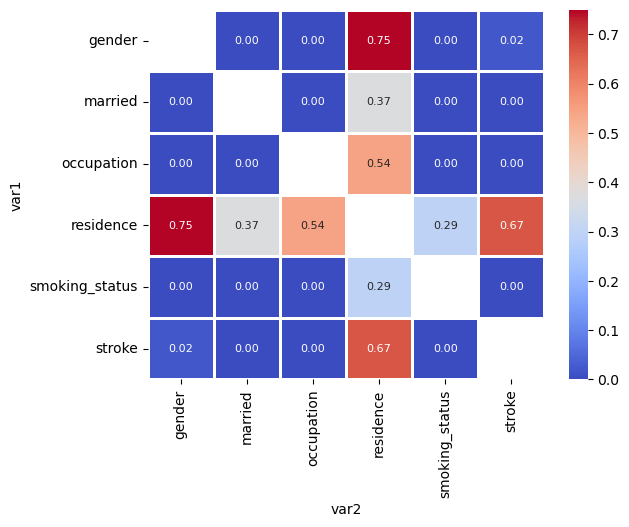

In [35]:
cat_var1 = catfeatures[:]
cat_var2 = catfeatures[:]
cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))

result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(\
                    pd.crosstab(df_mod[i[0]], df_mod[i[1]])))[1]))
        
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
chi_test_output = chi_test_output.round(3).pivot(index='var1', columns='var2', values='coeff')
sns.heatmap(chi_test_output, annot = True, fmt = ".2f", annot_kws = {"size": 8}, cmap = "coolwarm", linewidths = 1)
plt.show()

> **Observations:**
1. `residence` shows no signifcant relationship to `stroke`, can be considered to remove.

In [36]:
#crosstab evaluation
df1 = pd.crosstab(index=df_mod['gender'], columns=df_mod['married'])
#margins=True, margins_name="Total"
df1['married_rate_by_gender_%'] = df1.iloc[:, 1]/(df1.sum(axis = 1)) * 100
print(df1, "\n")

#crosstab evaluation
df2 = pd.crosstab(index=df_mod['occupation'], columns=df_mod['gender'])
#margins=True, margins_name="Total"
df2['male_by_occupation%'] = df2.iloc[:, 1]/(df2.sum(axis = 1)) * 100
print(df2, "\n")

#crosstab evaluation
df3 = pd.crosstab(index=df_mod['smoking_status'], columns=df_mod['gender'])
#margins=True, margins_name="Total"
df3['male_by_smoking_status%'] = df3.iloc[:, 1]/(df3.sum(axis = 1)) * 100
print(df3, "\n")

married    No    Yes  married_rate_by_gender_%
gender                                        
Female   8824  16839                 65.615867
Male     6631  11092                 62.585341 

gender      Female  Male  male_by_occupation%
occupation                                   
A             2976  3177            51.633350
B            15234  9591            38.634441
C              101    76            42.937853
D             4040  2753            40.527013
E             3312  2126            39.095256 

gender           Female  Male  male_by_smoking_status%
smoking_status                                        
Unknown            7298  5991                45.082399
formerly smoked    4116  3370                45.017366
never smoked      10568  5483                34.159865
smokes             3681  2879                43.887195 



In [37]:
#df_mod[df_mod['occupation'] == 'C']

#### Phi K correlation

In [38]:
new_feature = [i for i in df_mod.columns if i not in vif_feature ]
new_feature.remove('residence')
print(new_feature)

['gender', 'age', 'married', 'hypertension', 'heart_disease', 'occupation', 'metric_1', 'metric_3', 'smoking_status', 'stroke']


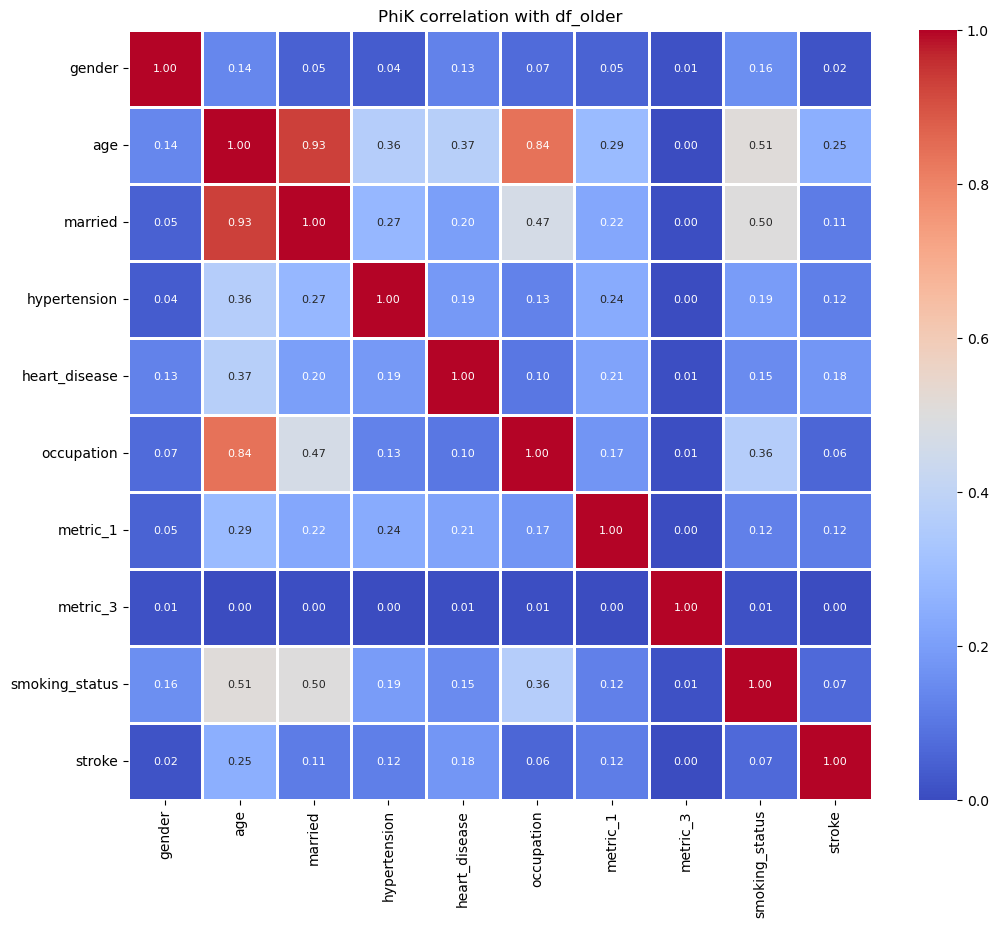

In [39]:
phik_overview = df_mod[new_feature].phik_matrix(interval_cols=numfeatures)
phik_overview.round(2)

plt.figure(figsize = (12,10), dpi = 100)
sns.heatmap(phik_overview, annot = True, fmt = ".2f", annot_kws = {"size": 8}, cmap = "coolwarm", linewidths = 1)
plt.title('PhiK correlation with df_older')
plt.show()

In [40]:
# #need to check significance
# significance_overview = df_mod[new_feature].significance_matrix(interval_cols=numfeatures)
# plt.figure(figsize = (12,10), dpi = 100)
# sns.heatmap(significance_overview, annot = True, fmt = ".1f", annot_kws = {"size": 8}, cmap = "coolwarm", linewidths = 1)
# plt.title('Significance of the coefficients')
# plt.show()

#### Correlation between `age` and `married`

In [130]:
married = df_mod['married'].map({'Yes':1, 'No': 0})
age = df_mod['age']

com_df = pd.concat([age, married], axis = 1)
com_df.corr()

,age,married
age,1.000000,0.693039
married,0.693039,1.000000


#### ANOVA
correlation between `age` and `Occupantion`
> ANOVA is used when the categorical variable has at least 3 groups.

 - Null hypothesis: The variables are not correlated with each other (**p < 0.05, reject**)
 - Alternative hypothesis: The variables are correlated with each other

In [42]:
# occupation and age one-way ANOVA
CategoryGroupLists=df_mod.groupby('occupation')['age'].apply(list)
print(CategoryGroupLists)
 
# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value > 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

occupation
A    [3.0, 3.0, 13.0, 4.0, 16.0, 13.0, 11.0, 8.0, 1...
B    [58.0, 8.0, 70.0, 47.0, 52.0, 32.0, 79.0, 37.0...
C    [14.0, 23.0, 19.0, 13.0, 17.0, 17.0, 13.0, 16....
D    [75.0, 74.0, 79.0, 70.0, 27.0, 17.0, 69.0, 53....
E    [79.0, 44.0, 67.0, 14.0, 45.0, 58.0, 51.0, 27....
Name: age, dtype: object
P-Value for Anova is:  0.0


#### Summary - Correlation:

Selected features after multivairate analysis: `gender`, `age`, `married`, `hypertension`, `heart_disease`, `occupation`, `metric_1`, `metric_3`, `smoking_status`


In [43]:
new_feature.remove('married')
new_feature.remove('occupation')
new_feature.remove('metric_3')

In [131]:
df_select = df_mod[new_feature]
display(df_select)

,gender,age,hypertension,heart_disease,metric_1,smoking_status,stroke
0,Male,3.0,0,0,95.12,Unknown,0
1,Male,58.0,1,0,87.96,never smoked,0
2,Female,8.0,0,0,110.89,Unknown,0
3,Female,70.0,0,0,69.04,formerly smoked,0
4,Male,14.0,0,0,161.28,Unknown,0
...,...,...,...,...,...,...,...
43381,Female,10.0,0,0,58.64,never smoked,0
43382,Female,56.0,0,0,213.61,formerly smoked,0
43383,Female,82.0,1,0,91.94,formerly smoked,0
43384,Male,40.0,0,0,99.16,never smoked,0


<a id='datapreprocessing'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">Data Preprocessing</h1>

## Encoding

In [138]:
gender_map = {'Female': 0, 'Male': 1}
#married_map = {'Yes':1, 'No': 0}
smoke_map = {'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3}

In [139]:
df_select['gender'] = df_select['gender'].map(gender_map)
#df_select['married'] = df_select['married'].map(married_map)
df_select['smoking_status'] = df_select['smoking_status'].map(smoke_map)
display(df_select)

,gender,age,hypertension,heart_disease,metric_1,smoking_status,stroke
0,1,3.0,0,0,95.12,0,0
1,1,58.0,1,0,87.96,1,0
2,0,8.0,0,0,110.89,0,0
3,0,70.0,0,0,69.04,2,0
4,1,14.0,0,0,161.28,0,0
...,...,...,...,...,...,...,...
43381,0,10.0,0,0,58.64,1,0
43382,0,56.0,0,0,213.61,2,0
43383,0,82.0,1,0,91.94,2,0
43384,1,40.0,0,0,99.16,1,0


In [47]:
#for one-hot encoding
# def find_cat(df):
#     cat =[]
#     for col in df.columns:
#         if df[col].dtype == 'O':
#             cat.append(col)
#     #print(cat)
#     return cat

# def onehot(X):
#     df = X.copy()
#     cat = find_cat(df)
#     df_cat = df[cat]
#     df_cat = pd.get_dummies(df_cat)
    
#     df = df.drop(cat, axis = 1)
#     df = pd.concat([df, df_cat], axis=1)
#     #print(df.head())
#     print(df.columns)
#     print(df.shape)
#     return df

In [48]:
# df_select = onehot(df_select)

In [49]:
#double check the mapping of dataframe
df_select.isna().sum()

gender            0
age               0
hypertension      0
heart_disease     0
metric_1          0
smoking_status    0
stroke            0
dtype: int64

## Customized metric: recall for positive class

In [50]:
#this metric is not business related
def recall_for_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[1], \
                           average = None, zero_division = 0)
custom_scorer = make_scorer(recall_for_class_1)

## Test and Train Split

In [51]:
def train_test_setup(df):
    features = list(df.columns)
    target = 'stroke'
    features.remove(target)
    X = df[features]
    y = df[target]
    
    #set random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state= 42)
    
    train_median = X_train.median()
    X_train.fillna(train_median, inplace = True)
    X_test.fillna(train_median, inplace = True)
    
    print("X Train : ", X_train.shape)
    print("X Test  : ", X_test.shape)
    print("Y Train : ", y_train.shape)
    print("Y Test  : ", y_test.shape)
    
    return X_train, X_test, y_train, y_test  

In [52]:
#get data from train-test split
X_train, X_test, y_train, y_test = train_test_setup(df_select)

X Train :  (20409, 6)
X Test  :  (8747, 6)
Y Train :  (20409,)
Y Test  :  (8747,)


<a id='model'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">Modeling</h1>

In [155]:
def evaluation(model, X_train, y_train, X_test, y_test):
    print('--------------------Train data--------------------')
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)

    #summary report
    print("--------------------Report for Train Data: --------------------")
    print(classification_report(y_train, y_train_pred))

    #confusion matrix
    print("Confusion Matrix for train data: \n")
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
    plt.show()

    #test data
    print('--------------------Test data--------------------')
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    #test - summary report
    print("--------------------Report for Test Data: --------------------")
    print(classification_report(y_test, y_test_pred))

    #test - confusion matrix
    print("--------------------Confusion Matrix for test data: -------------------- \n")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
    plt.show()

    print('------------------------------ROC-AUC Curve------------------------------')
    fpr, tpr, _ = roc_curve(y_test,  y_test_proba[:, -1])
    auc = roc_auc_score(y_test, y_test_proba[:, -1])
    plt.plot(fpr, tpr,label=f", auc={auc:.3f}")
    plt.legend(loc=4)
    plt.show()

## Generalized Linear Model - Logistic Regression

### Use class_weight to balance

In [53]:
steps = [
    ('scaler', RobustScaler()),
    ('logr', LogisticRegression(class_weight = 'balanced', max_iter = 1000)) #max_iter default = 100
]
params = [{'logr__solver': ['newton-cg','sag', 'saga','lbfgs', 'liblinear'],
          'logr__C': [0.001, 0.01, 0.1, 0.5, 0.8, 0.9, 1.0]
          }]
# solver: Algorithm to use in the optimization problem, default: 'lbfgs'
# C: Inverse of regularization strength
logr = Pipeline(steps)
gs_logr = GridSearchCV(logr, param_grid=params, scoring=custom_scorer , n_jobs = -1, error_score='raise')
gs_logr = gs_logr.fit(X_train, y_train)

print(gs_logr.best_params_)
print(gs_logr.best_score_)

# {'logr__C': 0.01, 'logr__solver': 'lbfgs'}
# 0.8582369530268494

/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linea

/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongjiang/.local/lib/python3.9/site-packages/sklearn/linea

{'logr__C': 0.5, 'logr__solver': 'saga'}
0.796330275229358


Report for Train Data:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     19864
           1       0.06      0.73      0.11       545

    accuracy                           0.70     20409
   macro avg       0.53      0.71      0.47     20409
weighted avg       0.96      0.70      0.80     20409

Report for Test Data:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      8513
           1       0.06      0.76      0.12       234

    accuracy                           0.69      8747
   macro avg       0.53      0.73      0.47      8747
weighted avg       0.97      0.69      0.80      8747

Confusion Matrix for train data: 



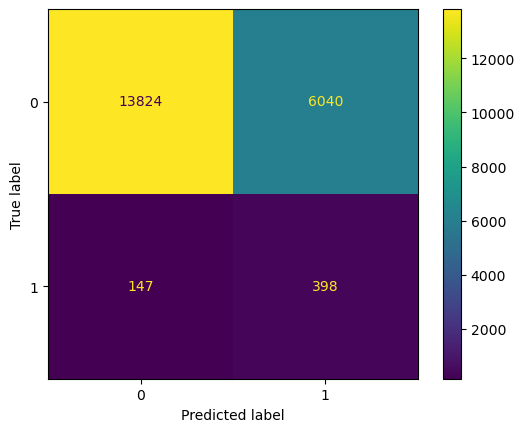

Confusion Matrix for test data: 



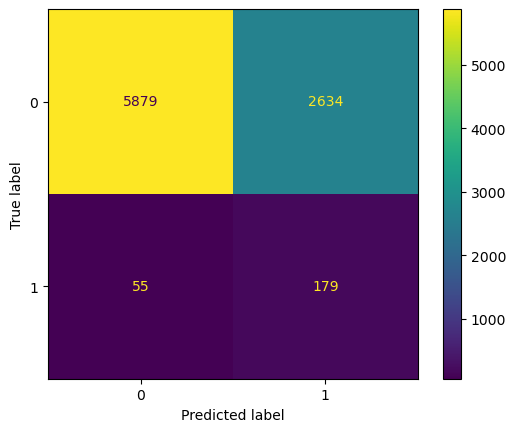

In [54]:
model = gs_logr.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Report for Train Data:")
print(classification_report(y_train, y_train_pred))
print("Report for Test Data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix for train data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
plt.show()
print("Confusion Matrix for test data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

> ROC-AUC curve and score for logistic regression

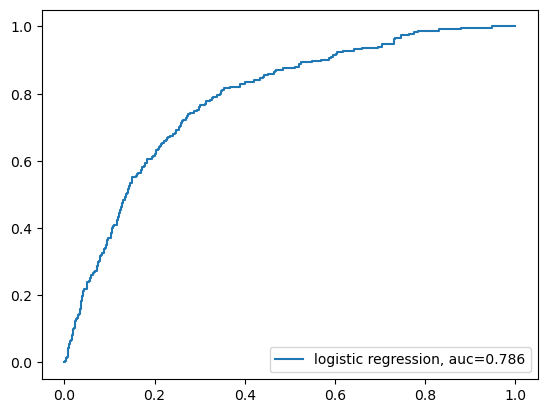

In [55]:
y_pred_proba = model.predict_proba(X_test)[::,-1]
fpr_lr, tpr_lr, _lr = roc_curve(y_test,  y_pred_proba)
auc_lr = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_lr,tpr_lr,label=f"logistic regression, auc={auc_lr:.3f}")
plt.legend(loc=4)
plt.show()

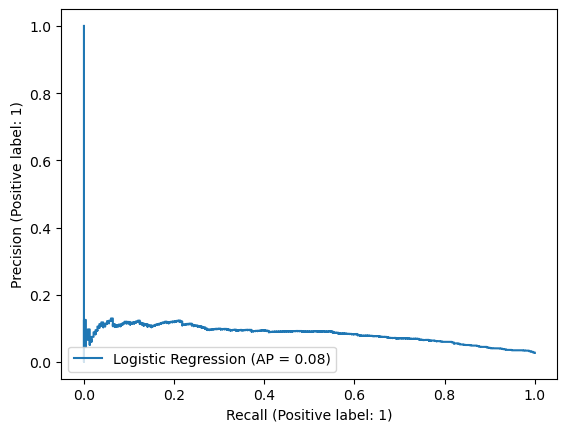

In [56]:
plot_precision_recall_curve(model, X_test, y_test, name = 'Logistic Regression')

### Use SMOTE: Oversampling method

In [57]:
steps = [
    ('smote', SMOTE(random_state=11)),
    ('scaler', RobustScaler()),
    ('logr', LogisticRegression(class_weight = 'balanced', max_iter = 1000)) #max_iter default = 100
]

params = [{'logr__solver': ['newton-cg','sag', 'saga','lbfgs', 'liblinear'],
          'logr__C': [0.001, 0.01, 0.1, 0.5, 0.8, 0.9, 1.0]
          }]
logr = imbpipeline(steps) #use pipeline from imbalance package
gs_logr = GridSearchCV(logr, param_grid=params, scoring=custom_scorer , n_jobs = -1, error_score='raise')
gs_logr = gs_logr.fit(X_train, y_train)

print(gs_logr.best_params_)
print(gs_logr.best_score_)

{'logr__C': 0.001, 'logr__solver': 'newton-cg'}
0.6128440366972476


Report for Train Data:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     19864
           1       0.06      0.61      0.10       545

    accuracy                           0.71     20409
   macro avg       0.52      0.66      0.47     20409
weighted avg       0.96      0.71      0.81     20409

Report for Test Data:
              precision    recall  f1-score   support

           0       0.99      0.71      0.82      8513
           1       0.06      0.62      0.10       234

    accuracy                           0.71      8747
   macro avg       0.52      0.66      0.46      8747
weighted avg       0.96      0.71      0.80      8747

Confusion Matrix for train data: 



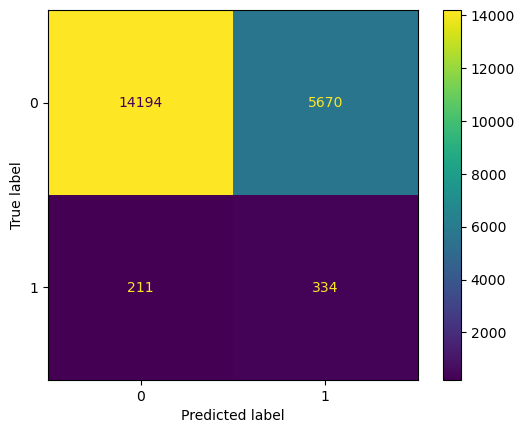

Confusion Matrix for test data: 



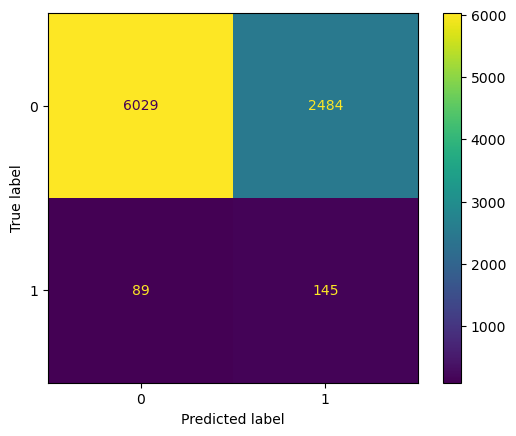

In [58]:
model = gs_logr.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Report for Train Data:")
print(classification_report(y_train, y_train_pred))
print("Report for Test Data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix for train data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
plt.show()
print("Confusion Matrix for test data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

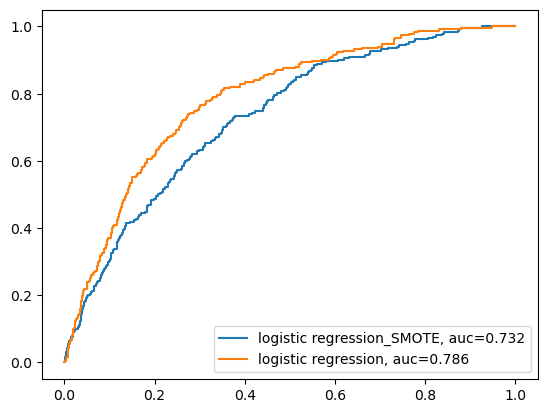

In [59]:
y_pred_proba = model.predict_proba(X_test)[::,-1]
fpr_lr_smote, tpr_lr_smote, _lr_smote = roc_curve(y_test,  y_pred_proba)
auc_lr_smote = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_lr_smote,tpr_lr_smote,label=f"logistic regression_SMOTE, auc={auc_lr_smote:.3f}")
plt.plot(fpr_lr,tpr_lr,label=f"logistic regression, auc={auc_lr:.3f}")
plt.legend(loc=4)
plt.show()

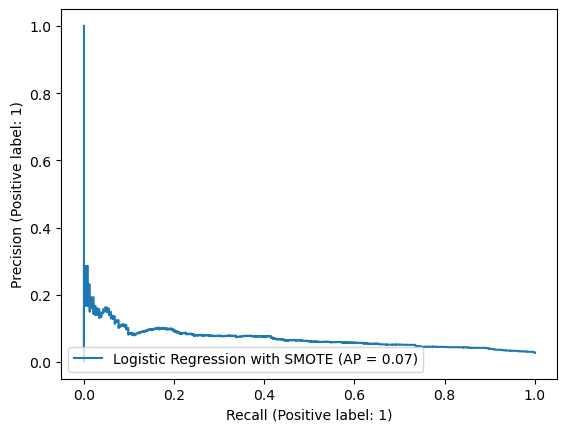

In [60]:
plot_precision_recall_curve(model, X_test, y_test, name = 'Logistic Regression with SMOTE')

> Note:
If I have more time, 
- I will try other upsampling methods, including ADASYN (uses a density distribution, as a criterion to automatically decide the number of synthetic samples that must be generated for each minority sample by adaptively changing the weights of the different minority samples to compensate for the skewed distributions.)
- Downsampling method: Neighborhood Cleaning Rule to adjust the imbnalance data.

## RandomForestClassifier

### Use class_weight to balance

In [61]:
#double check with train and test dataset
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20409, 6) (8747, 6) (20409,) (8747,)


In [62]:
params = [{'rf__n_estimators': list(range(100, 200, 10)),
           'rf__max_depth': list(range(3, 10, 1)),
           'rf__max_features': list(range(2, 6, 1)),
           'rf__max_samples': list(np.linspace(0.4, 0.9, 4))
          }]

steps = [
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 9))
]
rfc = Pipeline(steps)

rs_rfc = RandomizedSearchCV(rfc, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')


rs_rfc = rs_rfc.fit(X_train, y_train)

print(rs_rfc.best_params_)
print(rs_rfc.best_score_)

# {'rf__random_state': 9, 'rf__n_estimators': 110, 'rf__max_samples': 0.9, 'rf__max_features': 4, 'rf__max_depth': 3}
# 0.856734558879146

{'rf__n_estimators': 100, 'rf__max_samples': 0.9, 'rf__max_features': 2, 'rf__max_depth': 3}
0.7541284403669725


Report for Train Data:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     19864
           1       0.06      0.80      0.11       545

    accuracy                           0.67     20409
   macro avg       0.53      0.73      0.45     20409
weighted avg       0.97      0.67      0.78     20409

Report for Test Data:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      8513
           1       0.06      0.80      0.11       234

    accuracy                           0.66      8747
   macro avg       0.53      0.73      0.45      8747
weighted avg       0.97      0.66      0.77      8747

Confusion Matrix for train data: 



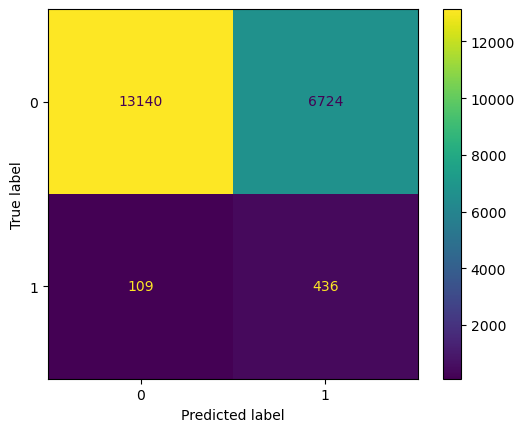

Confusion Matrix for test data: 



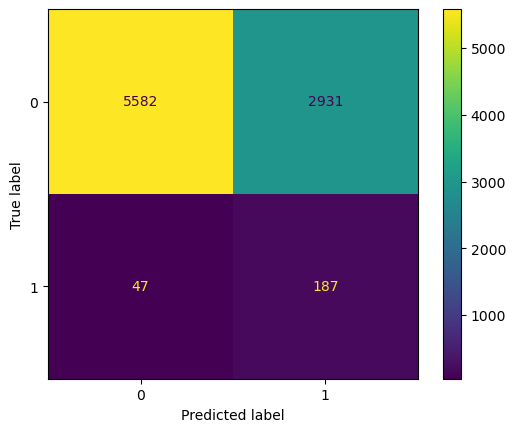

Train ROC AUC score 0.789544914593548
Test ROC AUC score 0.7804087464019333


In [63]:
model = rs_rfc.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Report for Train Data:")
print(classification_report(y_train, y_train_pred))
print("Report for Test Data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix for train data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
plt.show()
print("Confusion Matrix for test data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

print('Train ROC AUC score',roc_auc_score(y_train, y_train_proba[:, -1]))
print('Test ROC AUC score',roc_auc_score(y_test, y_test_proba[:, -1]))

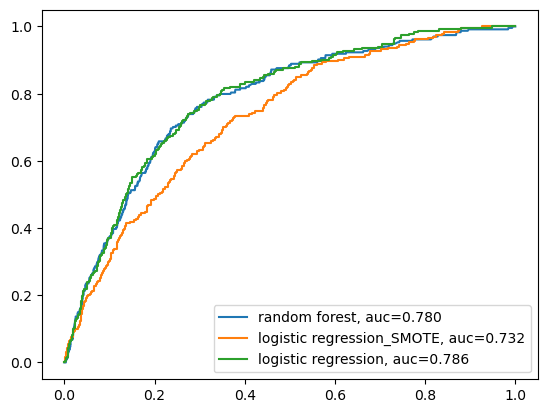

In [64]:
y_pred_proba = model.predict_proba(X_test)[::,-1]
fpr_rf, tpr_rf, _rf = roc_curve(y_test,  y_pred_proba)
auc_rf = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_rf,tpr_rf,label=f"random forest, auc={auc_rf:.3f}")

#auc_roc from logistic regression
plt.plot(fpr_lr_smote,tpr_lr_smote,label=f"logistic regression_SMOTE, auc={auc_lr_smote:.3f}")
plt.plot(fpr_lr,tpr_lr,label=f"logistic regression, auc={auc_lr:.3f}")
plt.legend(loc=4)
plt.show()

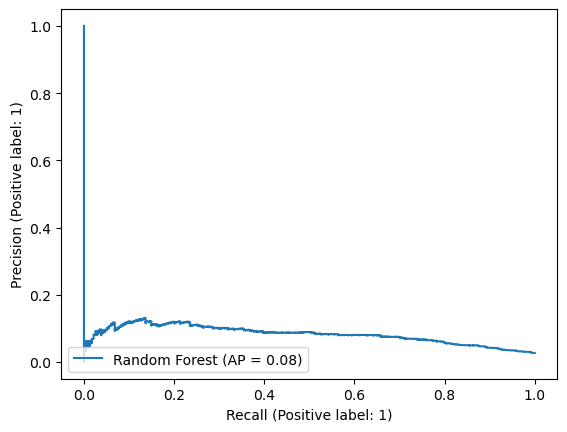

In [65]:
plot_precision_recall_curve(model, X_test, y_test, name = 'Random Forest')

### Important features

> `smoking_status` and `gender` have low feature importance

In [66]:
#feature importance
d = {'Features':X_train.columns,'Importance':model[-1].feature_importances_}
fi_df = pd.DataFrame(d)
fi_df = fi_df.sort_values(by=['Importance'], ascending=False)
display(fi_df)

,Features,Importance
1,age,0.620259
3,heart_disease,0.167003
4,metric_1,0.119908
2,hypertension,0.070983
5,smoking_status,0.014503
0,gender,0.007343


> `gender` are not very important features

In [67]:
def make_train_test_by_feature_importance(df, fi, num=10):
    feature_names = fi.iloc[:, 0].values.tolist()[:num]
    feature_names.append('stroke')
    new_df = df[feature_names].copy()
    #print(new_df)
    X_train, X_test, y_train, y_test = train_test_setup(new_df)
    
    return X_train, X_test, y_train, y_test

In [68]:
X_train, X_test, y_train, y_test = make_train_test_by_feature_importance(df_select, fi_df, 5)

X Train :  (20409, 5)
X Test  :  (8747, 5)
Y Train :  (20409,)
Y Test  :  (8747,)


> Random forest model with 9 most important features, importance > 0.01

{'rf__n_estimators': 120, 'rf__max_samples': 0.9, 'rf__max_features': 3, 'rf__max_depth': 2}
0.7651376146788991
Report for Train Data:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     19864
           1       0.06      0.78      0.10       545

    accuracy                           0.64     20409
   macro avg       0.52      0.71      0.44     20409
weighted avg       0.97      0.64      0.75     20409

Report for Test Data:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      8513
           1       0.06      0.79      0.10       234

    accuracy                           0.64      8747
   macro avg       0.52      0.71      0.44      8747
weighted avg       0.97      0.64      0.75      8747

Confusion Matrix for train data: 



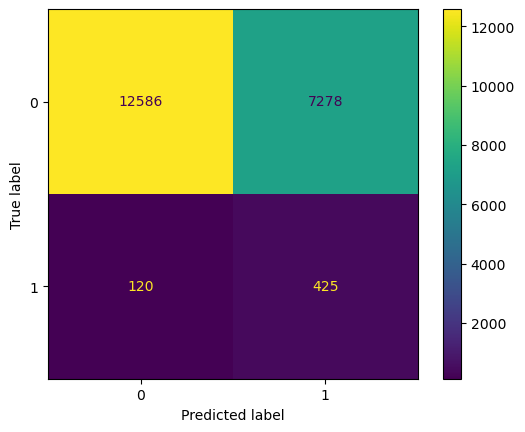

Confusion Matrix for test data: 



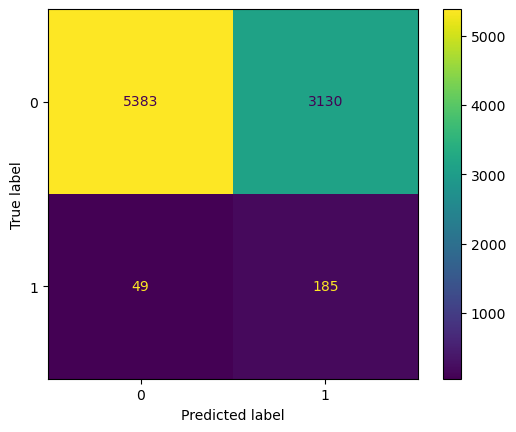

Train ROC AUC score 0.7828139144346695
Test ROC AUC score 0.7804270693087796


In [69]:
params = [{'rf__n_estimators': list(range(100, 200, 10)),
           'rf__max_depth': list(range(2, 6, 1)),
           'rf__max_features': list(range(2, 4, 1)),
           'rf__max_samples': list(np.linspace(0.4, 0.9, 4)),
          }]

steps = [
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 9))
]
rfc = Pipeline(steps)

rs_rfc = RandomizedSearchCV(rfc, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')


rs_rfc = rs_rfc.fit(X_train, y_train)

print(rs_rfc.best_params_)
print(rs_rfc.best_score_)

model = rs_rfc.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Report for Train Data:")
print(classification_report(y_train, y_train_pred))
print("Report for Test Data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix for train data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
plt.show()
print("Confusion Matrix for test data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

print('Train ROC AUC score',roc_auc_score(y_train, y_train_proba[:, -1]))
print('Test ROC AUC score',roc_auc_score(y_test, y_test_proba[:, -1]))

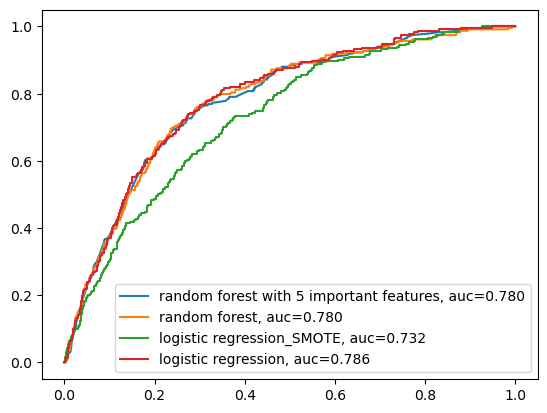

In [70]:
y_pred_proba = model.predict_proba(X_test)[::,-1]
fpr_rf_fi, tpr_rf_fi, _rf_fi = roc_curve(y_test,  y_pred_proba)
auc_rf_fi = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_rf_fi,tpr_rf_fi,label=f"random forest with 5 important features, auc={auc_rf_fi:.3f}")

plt.plot(fpr_rf,tpr_rf,label=f"random forest, auc={auc_rf:.3f}")
#auc_roc from logistic regression
plt.plot(fpr_lr_smote,tpr_lr_smote,label=f"logistic regression_SMOTE, auc={auc_lr_smote:.3f}")
plt.plot(fpr_lr,tpr_lr,label=f"logistic regression, auc={auc_lr:.3f}")
plt.legend(loc=4)
plt.show()

## XGBClassifier

`scale_pos_weight` is the ratio of number of negative class to the positive class

In [71]:
#set weight to balance
weight = (df_select['stroke'] == 0).sum()/(df_select['stroke'] == 1).sum()

In [72]:
params = [{'xgb__n_estimators': list(range(100, 300, 10)),
           'xgb__learning_rate': list(np.linspace(0.01, 0.2, 5)),
           'xgb__max_depth': [2, 3, 4, 5, 6],
           'xgb__subsample': [0.6, 0.7, 0.8],
           'xgb__colsample_bytree': list(np.linspace(0.1, 0.5, 5)),
           'xgb__gamma': [0, 1],
           'xgb__random_state': list(range(0, 30, 1))
          }]

steps = [
    ('scaler', RobustScaler()),
    ('xgb', XGBClassifier(scale_pos_weight = weight, random_state = 0))
]

xgb = Pipeline(steps)

rs_xgb = RandomizedSearchCV(xgb, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')
rs_xgb = rs_rfc.fit(X_train, y_train)

print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'rf__n_estimators': 100, 'rf__max_samples': 0.9, 'rf__max_features': 3, 'rf__max_depth': 2}
0.7669724770642203


Report for Train Data:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     19864
           1       0.05      0.78      0.10       545

    accuracy                           0.62     20409
   macro avg       0.52      0.70      0.43     20409
weighted avg       0.97      0.62      0.74     20409

Report for Test Data:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      8513
           1       0.05      0.79      0.10       234

    accuracy                           0.62      8747
   macro avg       0.52      0.70      0.43      8747
weighted avg       0.97      0.62      0.74      8747

Confusion Matrix for train data: 



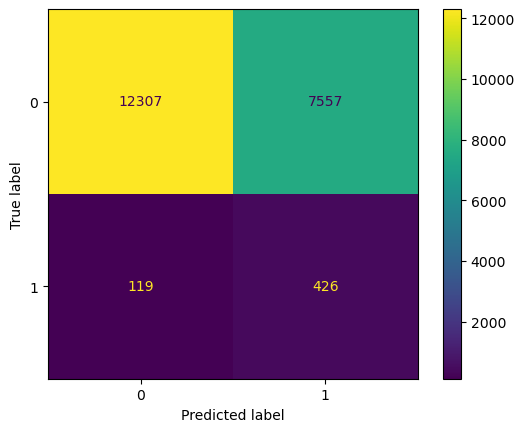

Confusion Matrix for test data: 



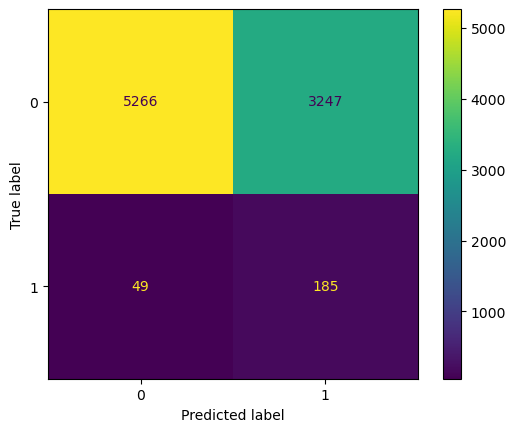

Train ROC AUC score 0.7826012758316183
Test ROC AUC score 0.7812285082342642


In [73]:
#model = gs_xgb.best_estimator_
model = rs_xgb.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Report for Train Data:")
print(classification_report(y_train, y_train_pred))
print("Report for Test Data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix for train data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
plt.show()
print("Confusion Matrix for test data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

print('Train ROC AUC score',roc_auc_score(y_train, y_train_proba[:, -1]))
print('Test ROC AUC score',roc_auc_score(y_test, y_test_proba[:, -1]))

## Summary of AUC-ROC of models

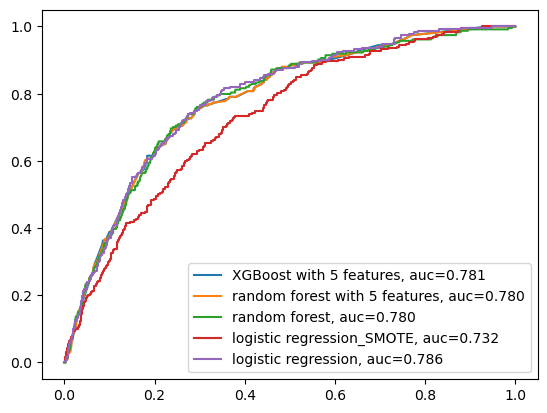

In [74]:
y_pred_proba = model.predict_proba(X_test)[::,-1]
fpr_xgb_fi, tpr_xgb_fi, _xgb_fi = roc_curve(y_test,  y_pred_proba)
auc_xgb_fi = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_xgb_fi, tpr_xgb_fi,label=f"XGBoost with 5 features, auc={auc_xgb_fi:.3f}")
#random forest
plt.plot(fpr_rf_fi,tpr_rf_fi,label=f"random forest with 5 features, auc={auc_rf_fi:.3f}")
plt.plot(fpr_rf,tpr_rf,label=f"random forest, auc={auc_rf:.3f}")
#logistic regression
plt.plot(fpr_lr_smote,tpr_lr_smote,label=f"logistic regression_SMOTE, auc={auc_lr_smote:.3f}")
plt.plot(fpr_lr,tpr_lr,label=f"logistic regression, auc={auc_lr:.3f}")

plt.legend(loc=4)
plt.show()

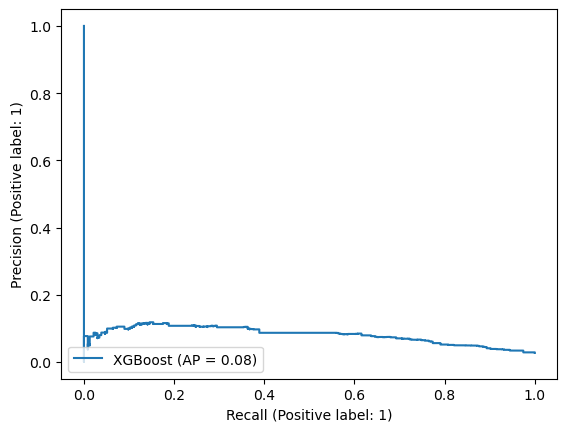

In [75]:
plot_precision_recall_curve(model, X_test, y_test, name = 'XGBoost')

> XGBoost with 4 features has similar performance as random forest with the same features. XGBoost is faster than random forest.

## End-to-end Model

In [76]:
#selected features from feature importance
selected_features = df_select.columns.to_list()
selected_features.remove('gender')
print(selected_features)

['age', 'hypertension', 'heart_disease', 'metric_1', 'smoking_status', 'stroke']


Train and Test data were splited.
X_Train data shape (30370, 5), y_train data shape(30370,)
X_Train data shape (13016, 5), y_train data shape(13016,)
---------------Searching for optimized hyperparameter combination---------------
---------------Use 5 fold cross validation---------------
The best hyperparamer combination is: {'xgb__subsample': 0.7, 'xgb__random_state': 4, 'xgb__n_estimators': 170, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.0575, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.4}
The best score for this searching is: 0.858018853596141
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     29822
           1       0.06      0.82      0.11       548

    accuracy                           0.76     30370
   macro avg       0.53      0.79      0.49     30370
weighted avg       0.98      0.76      0.85     30370

Con

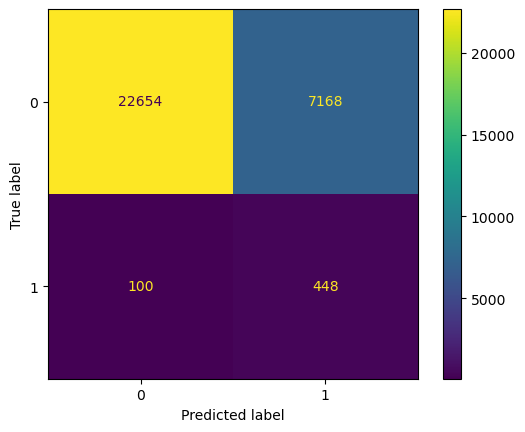

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     12781
           1       0.05      0.75      0.10       235

    accuracy                           0.76     13016
   macro avg       0.52      0.76      0.48     13016
weighted avg       0.98      0.76      0.85     13016

--------------------Confusion Matrix for test data: -------------------- 



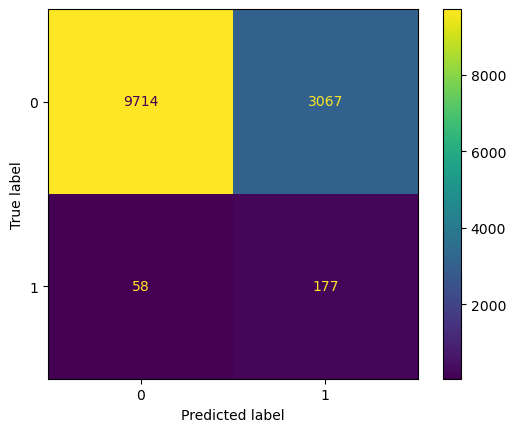

------------------------------ROC-AUC Curve------------------------------


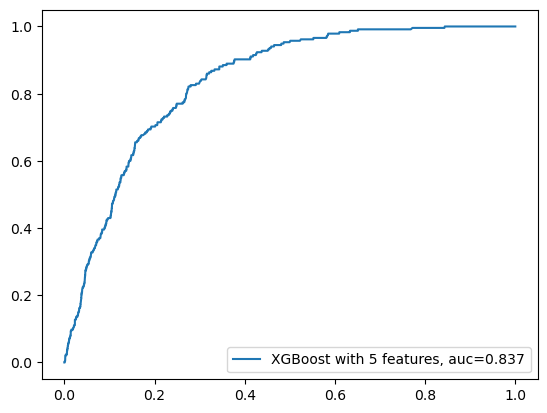

In [122]:
#load data
df = pd.read_csv('stroke data.csv')

#select features:
df = df[selected_features]
#remove outliers
df = df[~df.index.isin(outliers)]
print(df.shape)

#determine weight for imbalance data
weight = (df['stroke'] == 0).sum()/(df['stroke'] == 1).sum()

#assign target and split Train and Test
y = df.stroke
X = df.drop(['stroke'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state= 42)

# shapes
print(f'Train and Test data were splited.')
print(f'X_Train data shape {X_train.shape}, y_train data shape{y_train.shape}')
print(f'X_Train data shape {X_test.shape}, y_train data shape{y_test.shape}')

#transform features
class Data_Transformer():
    smoke_map = {'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3}
    def fit(self, X, y=None):
        df = X.copy()
        df = df.fillna('Unknown')
        df['smoking_status'] = X['smoking_status'].map(smoke_map)
        
    def transform(self, X, y = None):
        df = X.copy()
        df = df.fillna('Unknown')
        df['smoking_status'] = X['smoking_status'].map(smoke_map)
        return df
        
    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)

#pipeline, hyperparameter selection, model validation
params = [{'xgb__n_estimators': list(range(100, 300, 10)),
           'xgb__learning_rate': list(np.linspace(0.01, 0.2, 5)),
           'xgb__max_depth': [2, 3, 4, 5, 6],
           'xgb__subsample': [0.6, 0.7, 0.8],
           'xgb__colsample_bytree': list(np.linspace(0.1, 0.5, 5)),
           'xgb__gamma': [0, 1],
           'xgb__random_state': list(range(0, 30, 1))
           
          }]
steps = [
    ('tfr', Data_Transformer()),
    ('scaler', RobustScaler()),
    ('xgb', XGBClassifier(scale_pos_weight = weight))
]

xgb = Pipeline(steps)

print("---------------Searching for optimized hyperparameter combination---------------")
cv = 5
print(f"---------------Use {cv} fold cross validation---------------")
rs_xgb = RandomizedSearchCV(xgb, param_distributions = params, n_iter = 300, cv = cv,\
                            scoring = 'roc_auc', n_jobs = -1, error_score='raise')
rs_xgb = rs_xgb.fit(X_train, y_train)

print(f'The best hyperparamer combination is:', rs_xgb.best_params_)
print(f'The best score for this searching is:', rs_xgb.best_score_)

#final model
model = rs_xgb.best_estimator_

#train data
print('--------------------Train data--------------------')
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

#summary report
print("--------------------Report for Train Data: --------------------")
print(classification_report(y_train, y_train_pred))

#confusion matrix
print("Confusion Matrix for train data: \n")
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()
plt.show()

#test data
print('--------------------Test data--------------------')
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)

#test - summary report
print("--------------------Report for Test Data: --------------------")
print(classification_report(y_test, y_test_pred))

#test - confusion matrix
print("--------------------Confusion Matrix for test data: -------------------- \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

print('------------------------------ROC-AUC Curve------------------------------')
fpr_final, tpr_final, _final = roc_curve(y_test,  y_test_proba[:, -1])
auc_final = roc_auc_score(y_test, y_test_proba[:, -1])
plt.plot(fpr_final, tpr_final,label=f"XGBoost with 5 features, auc={auc_final:.3f}")
plt.legend(loc=4)
plt.show()

In [123]:
#feature importance
d = {'Features':X_train.columns,'Importance':model[-1].feature_importances_}
fi_df = pd.DataFrame(d)
fi_df = fi_df.sort_values(by=['Importance'], ascending=False)
display(fi_df)

,Features,Importance
0,age,0.556610
2,heart_disease,0.219852
1,hypertension,0.094927
3,metric_1,0.094296
4,smoking_status,0.034314


In [124]:
X_train.dtypes

age               float64
hypertension        int64
heart_disease       int64
metric_1          float64
smoking_status     object
dtype: object

In [125]:
a = X_train.iloc[1:3,:]

In [126]:
model.predict(a)

array([0, 0])

### Threshold Adjustment to identify the operating point
- With the scope, there is not enough information to make adjustment of threshold.

In [107]:
# Calculate the G-mean
# G-mean is the geometric mean of sensitivity (known as recall) and specificity.
gmean = np.sqrt(tpr_final * (1 - fpr_final))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(_final[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr_final[index], ndigits = 4)
tprOpt = round(tpr_final[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

Best Threshold: 0.4424000084400177 with G-Mean: 0.7711
FPR: 0.2979, TPR: 0.8468


In [108]:
# Calculate the Youden's J statistic
youdenJ = tpr_final - fpr_final

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(_final[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr_final[index], ndigits = 4)
tprOpt = round(tpr_final[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

Best Threshold: 0.4424000084400177 with Youden J statistic: 0.7711
FPR: 0.2979, TPR: 0.8468


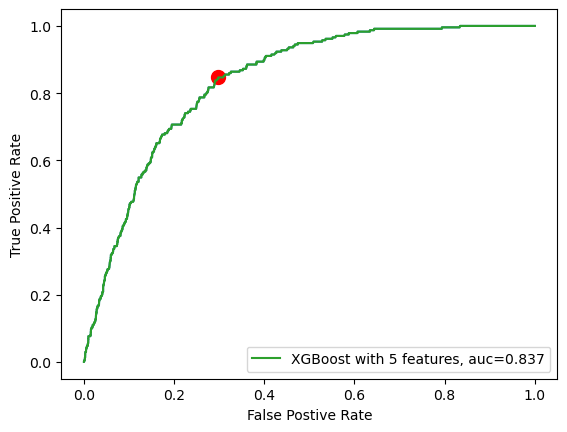

In [109]:
#plot to find optimal threshold with final model
plt.plot(fpr_final, tpr_final)
x = fprOpt
y = tprOpt
plt.plot(x, y, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_final, tpr_final,label=f"XGBoost with 5 features, auc={auc_final:.3f}")
plt.legend(loc=4)
plt.show()

In [116]:
print(f'false positive ratio is: {fprOpt}, true positive ratio/recall is {tprOpt}, and threshold is {thresholdOpt:.2f}.')

false positive ratio is: 0.2979, true positive ratio/recall is 0.8468, and threshold is 0.44.


--------------------Report for Test Data with threshold adjusted: --------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     12781
           1       0.05      0.83      0.09       235

    accuracy                           0.71     13016
   macro avg       0.52      0.77      0.46     13016
weighted avg       0.98      0.71      0.81     13016

Confusion Matrix for test data with threshold adjusted: 



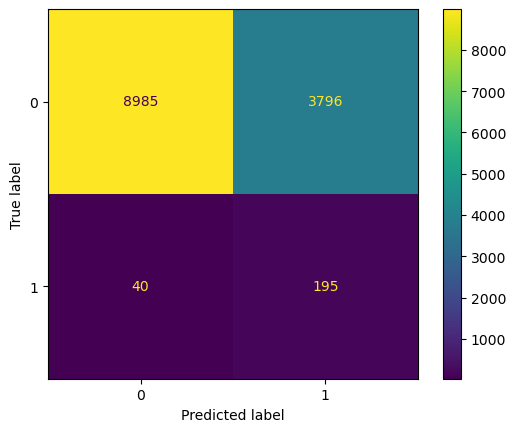

In [129]:
prob = y_test_proba[:, -1] #grap the probability from model prediction 
adjusted_predict = [1 if x > thresholdOpt else 0 for x in prob]

print("--------------------Report for Test Data with threshold adjusted: --------------------")
print(classification_report(y_test, adjusted_predict))

print("Confusion Matrix for test data with threshold adjusted: \n")
ConfusionMatrixDisplay(confusion_matrix(y_test, adjusted_predict)).plot()
plt.show()

## Post Model Evaluation - SHAP

In [82]:
x_a = model[:-1].transform(X_test)[3]

In [83]:
#load JS vis in the notebook
shap.initjs()

#set the tree explainer as the model of the pipeline
#imput X_test or X_train should be the same for individual sample
explainer = shap.TreeExplainer(model['xgb'], model[:-1].fit_transform(X_test), model_output="probability")

#calculate Shap values from preprocessed X_test
#it takes time
shap_values = explainer(model[:-1].fit_transform(X_test))

 98%|===================| 12779/13016 [00:21<00:00]        

In [84]:
shap_values.values

array([[ 5.07636282e-01, -7.33079506e-03, -6.21696311e-03,
         3.34204968e-02,  1.02960610e-02],
       [-2.44887311e-02, -8.72563843e-03, -8.70563707e-03,
        -1.99874075e-02,  2.85408675e-02],
       [ 5.15184038e-02, -9.11461508e-03, -8.86522490e-03,
        -5.36385698e-03,  3.21127643e-02],
       ...,
       [-2.17536849e-01, -5.50421615e-03, -6.04147652e-03,
        -8.49273551e-03,  1.82715211e-05],
       [ 3.93829217e-01, -8.84221069e-03, -8.02938038e-03,
        -5.68855622e-02,  1.01849412e-02],
       [ 1.16987444e-01, -9.08924342e-03, -8.86211480e-03,
        -2.68411389e-02, -2.13149383e-02]])

In [85]:
shap_features = selected_features[:-1]
shap_values.feature_names = shap_features
print(shap_values.feature_names)

['age', 'hypertension', 'heart_disease', 'metric_1', 'smoking_status']


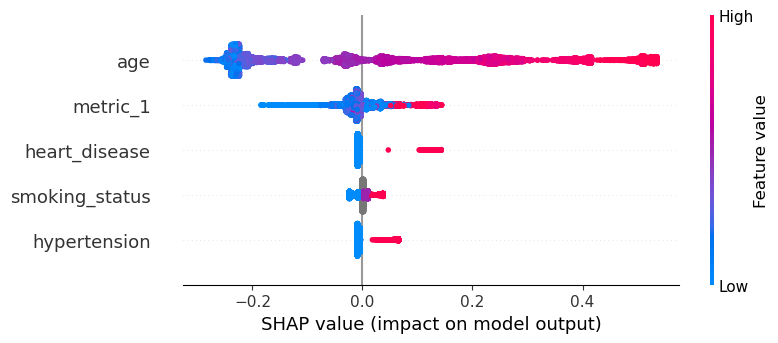

In [86]:
#population level
shap.plots.beeswarm(shap_values)

In [87]:
#select sample 3 from population batch test
shap.force_plot(shap_values[3])

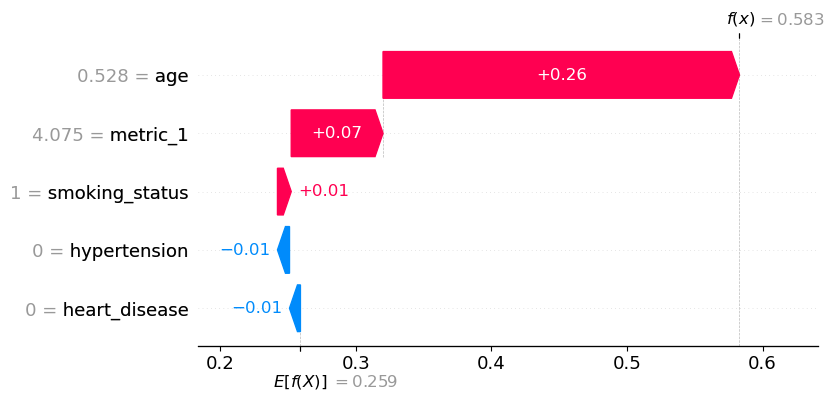

In [88]:
#select sample 3 from population batch test
shap.plots.waterfall(shap_values[3])

In [89]:
#individual test analysis
#preprocess the single data from x_a
observation = x_a
print(observation)

#calculate Shap values from a single observation
shap_value = explainer.shap_values(observation)
print(shap_value)

#plot the feature importance
shap.force_plot(explainer.expected_value, shap_value, observation, feature_names=shap_features)

[0.52777778 0.         0.         4.0522129  1.        ]
[ 0.26303643 -0.00886879 -0.00806721  0.06773827  0.010161  ]


The shap_values variable will have three attributes: `.values`, `.base_values` and `.data`

- The `.data` is simply a copy of the input data
- `.base_values` is the expected value of the target, or the average target value of all the train data
- `.values` are the SHAP values for each example.

<a id='conclusion'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center"> Summary</h1>

> Summary:
- Five features were found to be closely correlated to stroke. `age` has the most impact, the older, the higher tendency of stroke. Higher the `metric_1`, the tendency of stroke is higher. `heart_disease` and `hypertension` are positively correlated to stroke probability. People who `smokes` are more likely to stoke.
- The final xgboost model was able to correctly predict 83% of the high-risk members with 5% precision.
- Can I do better?

FIN.

<a id='extra'></a>
<h1 style="background-color:lightskyblue;font-family:monospace;font-size:250%;text-align:center">If i have more time ......?</h1>

1. Try other methods that can deal with imbalance data, such as downsampling, ensamble method and combinations of them.
2. Try seperate the age group and build different models, one group is for members older than 30, the other is for members younger than 30.
3. Try to understand the meaning of metric_1, 2, 3, 4 and see if there are any feature engineering can be performed.
4. Try other models such as SVM and neural network.
5. Spend more time tuning hyperparameters

In [140]:
#get data from train-test split
X_train, X_test, y_train, y_test = train_test_setup(df_select)

X Train :  (30370, 6)
X Test  :  (13016, 6)
Y Train :  (30370,)
Y Test  :  (13016,)


## upsampling with ADASYN

In [142]:
from imblearn.over_sampling import ADASYN

{'rf__n_estimators': 100, 'rf__max_samples': 0.4, 'rf__max_features': 5, 'rf__max_depth': 3}
0.8303586321934946
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     29822
           1       0.05      0.83      0.10       548

    accuracy                           0.72     30370
   macro avg       0.52      0.77      0.46     30370
weighted avg       0.98      0.72      0.82     30370

Confusion Matrix for train data: 



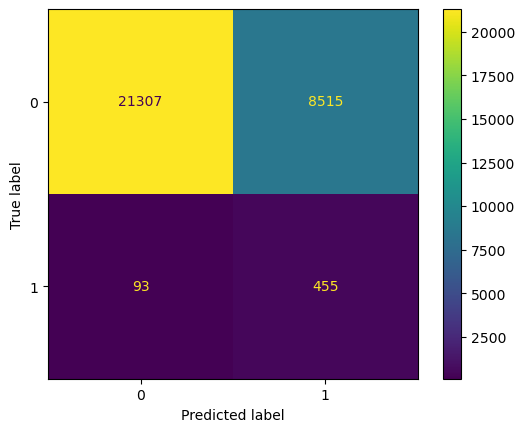

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     12781
           1       0.05      0.80      0.09       235

    accuracy                           0.71     13016
   macro avg       0.52      0.76      0.46     13016
weighted avg       0.98      0.71      0.82     13016

--------------------Confusion Matrix for test data: -------------------- 



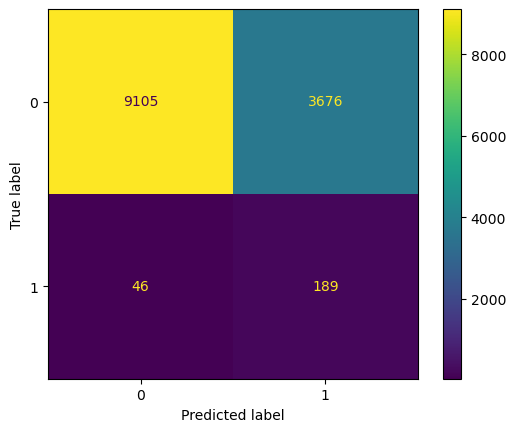

------------------------------ROC-AUC Curve------------------------------


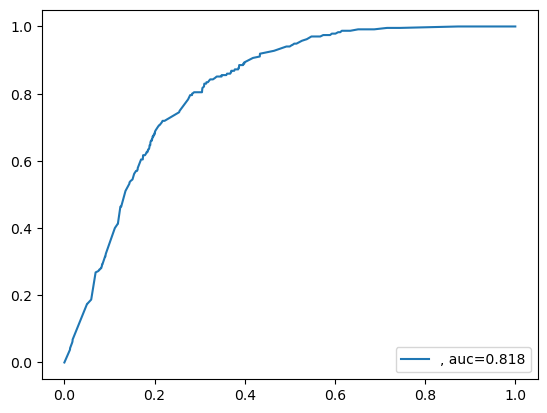

In [143]:
steps = [
    ('adasyn', ADASYN(random_state=0)),
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 0))
]

params = [{'rf__n_estimators': list(range(100, 200, 10)),
           'rf__max_depth': list(range(3, 10, 1)),
           'rf__max_features': list(range(2, 6, 1)),
           'rf__max_samples': list(np.linspace(0.4, 0.9, 4))
          }]

model = imbpipeline(steps) #use pipeline from imbalance package
rs_model = RandomizedSearchCV(model, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')
rs_model = rs_model.fit(X_train, y_train)

print(rs_model.best_params_)
print(rs_model.best_score_)

#final model
model = rs_model.best_estimator_

evaluation(model, X_train, y_train, X_test, y_test)

## Downsampling with NeighbourhoodCleaningRule

In [144]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [147]:
ncr = NeighbourhoodCleaningRule()
print(f'original size: {X_train.shape}, {y_train.shape}')
X_res, y_res = ncr.fit_resample(X_train, y_train)
print(f'downsampling size: {X_res.shape}, {y_res.shape}')

original size: (30370, 6), (30370,)
downsampling size: (28949, 6), (28949,)


{'rf__n_estimators': 140, 'rf__max_samples': 0.4, 'rf__max_features': 4, 'rf__max_depth': 3}
0.8339282735613012
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     29822
           1       0.05      0.84      0.09       548

    accuracy                           0.69     30370
   macro avg       0.52      0.77      0.45     30370
weighted avg       0.98      0.69      0.80     30370

Confusion Matrix for train data: 



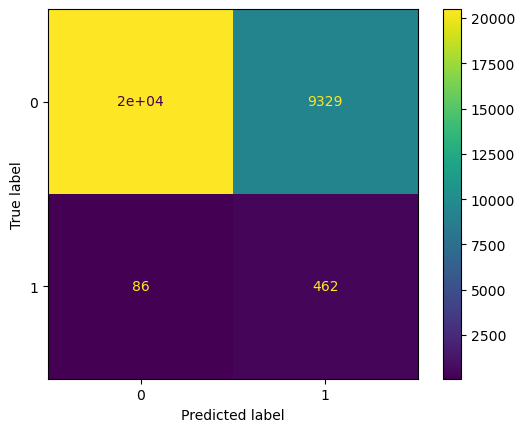

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     12781
           1       0.05      0.81      0.09       235

    accuracy                           0.69     13016
   macro avg       0.52      0.75      0.45     13016
weighted avg       0.98      0.69      0.80     13016

--------------------Confusion Matrix for test data: -------------------- 



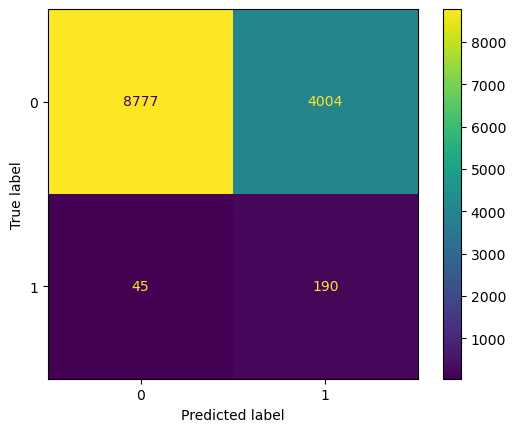

------------------------------ROC-AUC Curve------------------------------


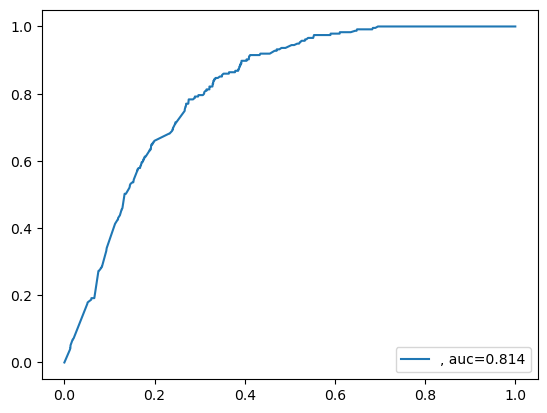

In [148]:
steps = [
    ('adasyn', ADASYN(random_state=0)),
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 0))
]

params = [{'rf__n_estimators': list(range(100, 200, 10)),
           'rf__max_depth': list(range(3, 10, 1)),
           'rf__max_features': list(range(2, 6, 1)),
           'rf__max_samples': list(np.linspace(0.4, 0.9, 4))
          }]

model = imbpipeline(steps) #use pipeline from imbalance package
rs_model = RandomizedSearchCV(model, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')
rs_model = rs_model.fit(X_res, y_res)

print(rs_model.best_params_)
print(rs_model.best_score_)

#final model
model = rs_model.best_estimator_

evaluation(model, X_train, y_train, X_test, y_test)

> include downsampling in the pipeline

{'rf__n_estimators': 180, 'rf__max_samples': 0.9, 'rf__max_features': 5, 'rf__max_depth': 3}
0.8413177648040033
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     29822
           1       0.05      0.84      0.09       548

    accuracy                           0.69     30370
   macro avg       0.52      0.77      0.45     30370
weighted avg       0.98      0.69      0.80     30370

Confusion Matrix for train data: 



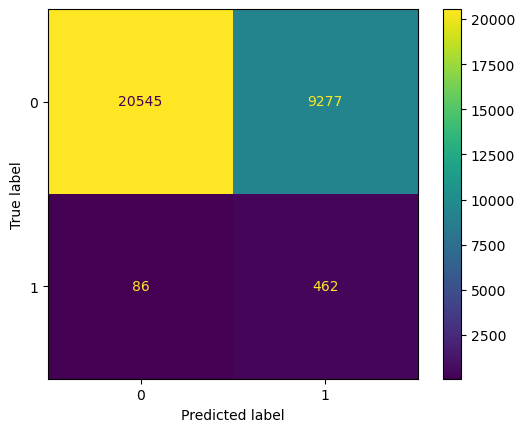

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     12781
           1       0.05      0.81      0.09       235

    accuracy                           0.69     13016
   macro avg       0.52      0.75      0.45     13016
weighted avg       0.98      0.69      0.80     13016

--------------------Confusion Matrix for test data: -------------------- 



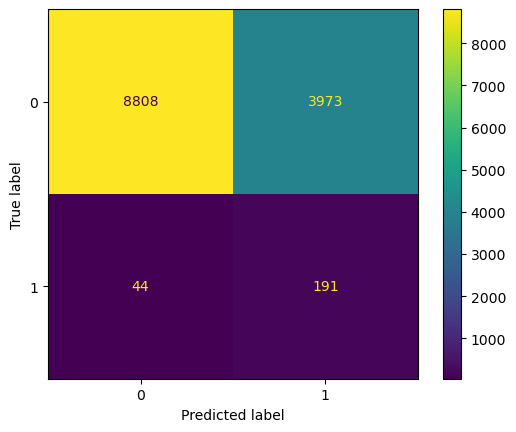

------------------------------ROC-AUC Curve------------------------------


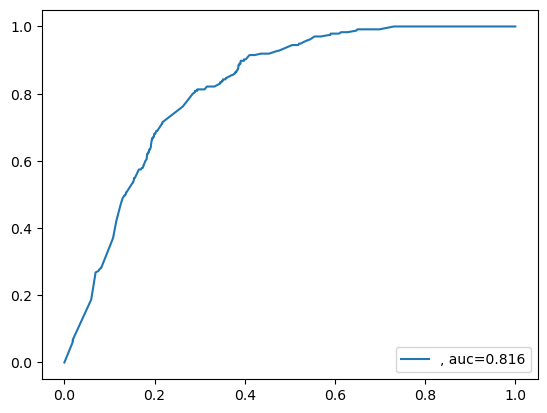

In [150]:
steps = [
    ('ncr', NeighbourhoodCleaningRule()),
    ('adasyn', ADASYN(random_state=0)),
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 0))
]

params = [{'rf__n_estimators': list(range(100, 200, 10)),
           'rf__max_depth': list(range(3, 10, 1)),
           'rf__max_features': list(range(2, 6, 1)),
           'rf__max_samples': list(np.linspace(0.4, 0.9, 4))
          }]

model = imbpipeline(steps) #use pipeline from imbalance package
rs_model = RandomizedSearchCV(model, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')
rs_model = rs_model.fit(X_train, y_train)

print(rs_model.best_params_)
print(rs_model.best_score_)

#final model
model = rs_model.best_estimator_

evaluation(model, X_train, y_train, X_test, y_test)

> TomekLinks: one way to find the data from the majority class that is closest with the minority class data, thus make it ambiguous to distinct. 

{'rf__n_estimators': 140, 'rf__max_samples': 0.5666666666666667, 'rf__max_features': 4, 'rf__max_depth': 3}
0.8248707256046706
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     29822
           1       0.05      0.83      0.09       548

    accuracy                           0.70     30370
   macro avg       0.52      0.76      0.46     30370
weighted avg       0.98      0.70      0.81     30370

Confusion Matrix for train data: 



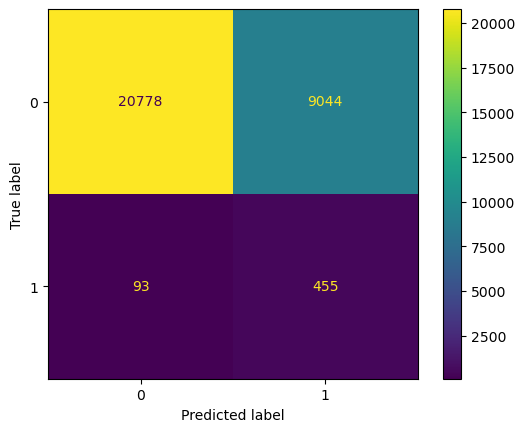

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     12781
           1       0.05      0.80      0.09       235

    accuracy                           0.70     13016
   macro avg       0.52      0.75      0.45     13016
weighted avg       0.98      0.70      0.81     13016

--------------------Confusion Matrix for test data: -------------------- 



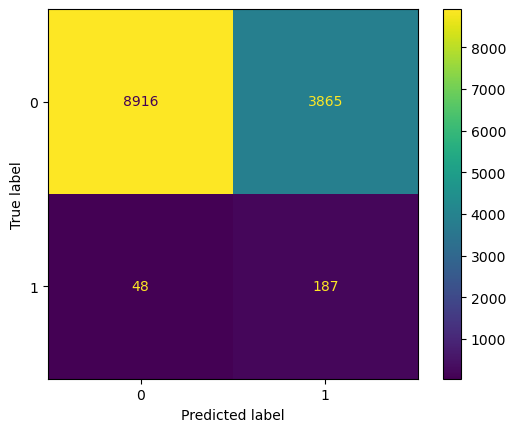

------------------------------ROC-AUC Curve------------------------------


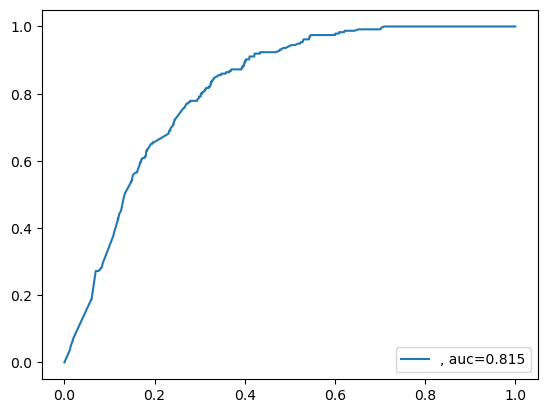

In [151]:
from imblearn.under_sampling import TomekLinks

steps = [
    ('ncr', TomekLinks()),
    ('adasyn', ADASYN(random_state=0)),
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 0))
]

params = [{'rf__n_estimators': list(range(100, 200, 10)),
           'rf__max_depth': list(range(3, 10, 1)),
           'rf__max_features': list(range(2, 6, 1)),
           'rf__max_samples': list(np.linspace(0.4, 0.9, 4))
          }]

model = imbpipeline(steps) #use pipeline from imbalance package
rs_model = RandomizedSearchCV(model, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')
rs_model = rs_model.fit(X_train, y_train)

print(rs_model.best_params_)
print(rs_model.best_score_)

#final model
model = rs_model.best_estimator_

evaluation(model, X_train, y_train, X_test, y_test)

## Ensemble

> EasyEnsembleClassifier
The classifier is an ensemble of AdaBoost learners trained on different balanced bootstrap samples. The balancing is achieved by random under-sampling.

In [152]:
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     29822
           1       0.05      0.85      0.10       548

    accuracy                           0.73     30370
   macro avg       0.53      0.79      0.47     30370
weighted avg       0.98      0.73      0.83     30370

Confusion Matrix for train data: 



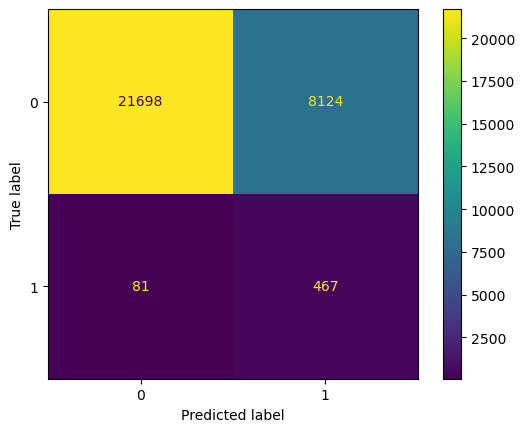

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.72      0.84     12781
           1       0.05      0.79      0.09       235

    accuracy                           0.72     13016
   macro avg       0.52      0.76      0.47     13016
weighted avg       0.98      0.72      0.82     13016

--------------------Confusion Matrix for test data: -------------------- 



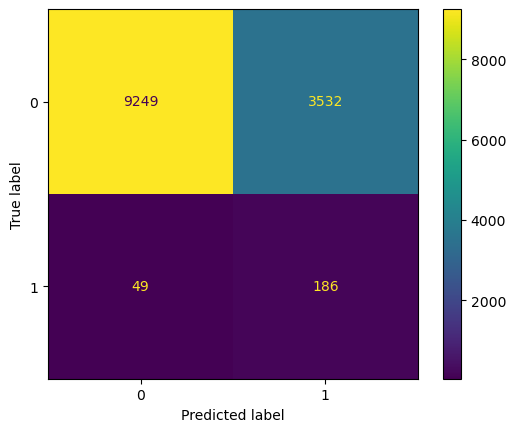

------------------------------ROC-AUC Curve------------------------------


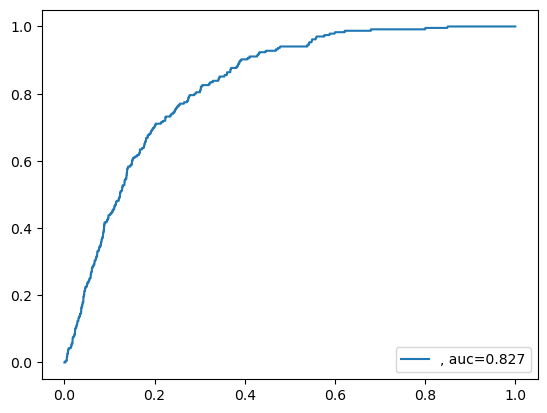

In [156]:
model = EasyEnsembleClassifier(random_state = 0)
model = model.fit(X_train, y_train)

evaluation(model, X_train, y_train, X_test, y_test)

{'max_samples': 0.2, 'estimator__n_estimators': 120, 'estimator__max_samples': 0.7333333333333334, 'estimator__max_features': 5, 'estimator__max_depth': 3}
0.8412677231025855
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     29822
           1       0.05      0.85      0.10       548

    accuracy                           0.71     30370
   macro avg       0.52      0.78      0.46     30370
weighted avg       0.98      0.71      0.81     30370

Confusion Matrix for train data: 



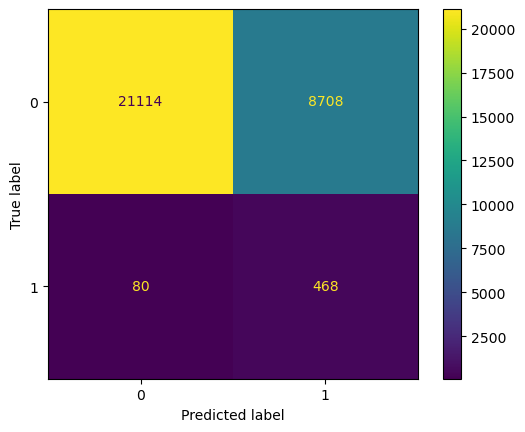

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     12781
           1       0.05      0.83      0.09       235

    accuracy                           0.71     13016
   macro avg       0.52      0.77      0.46     13016
weighted avg       0.98      0.71      0.81     13016

--------------------Confusion Matrix for test data: -------------------- 



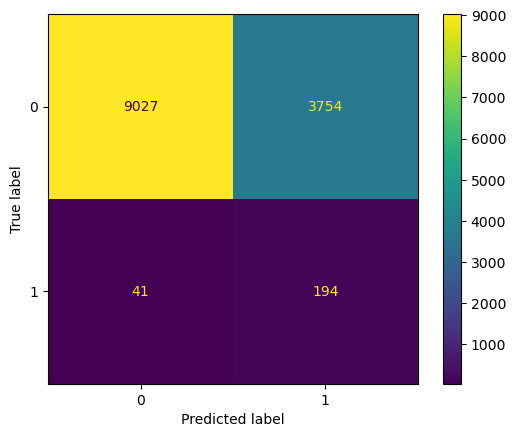

------------------------------ROC-AUC Curve------------------------------


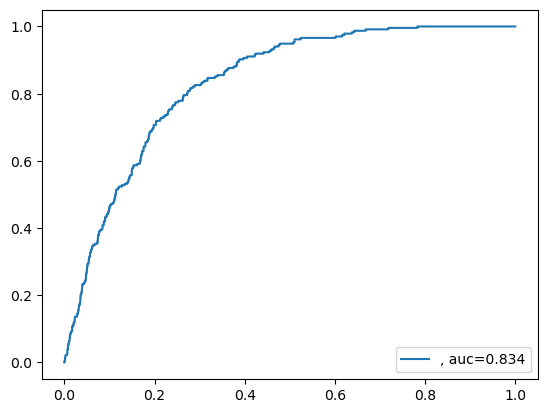

In [162]:
#ensemble model with random forest as a based, layer with balancebaggingclassifer. 
params = {
    'estimator__n_estimators': list(range(100, 200, 10)),
    'estimator__max_depth': list(range(3, 10, 1)),
    'estimator__max_features': list(range(2, 6, 1)),
    'estimator__max_samples': list(np.linspace(0.4, 0.9, 4)),
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

model = BalancedBaggingClassifier(RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 0),n_estimators = 50)
rs_model = RandomizedSearchCV(model, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')

rs_model = rs_model.fit(X_train, y_train)

print(rs_model.best_params_)
print(rs_model.best_score_)

model = rs_model.best_estimator_

evaluation(model, X_train, y_train, X_test, y_test)

#takes 55m to finish

In [164]:
#save BalancedBaggingClassifier + random_forest
bbc_rf_model = model

{'max_samples': 0.3, 'estimator__subsample': 0.8, 'estimator__n_estimators': 130, 'estimator__max_depth': 2, 'estimator__learning_rate': 0.105, 'estimator__gamma': 0, 'estimator__colsample_bytree': 0.5}
0.8284904086738949
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     29822
           1       0.06      0.83      0.11       548

    accuracy                           0.75     30370
   macro avg       0.53      0.79      0.48     30370
weighted avg       0.98      0.75      0.84     30370

Confusion Matrix for train data: 



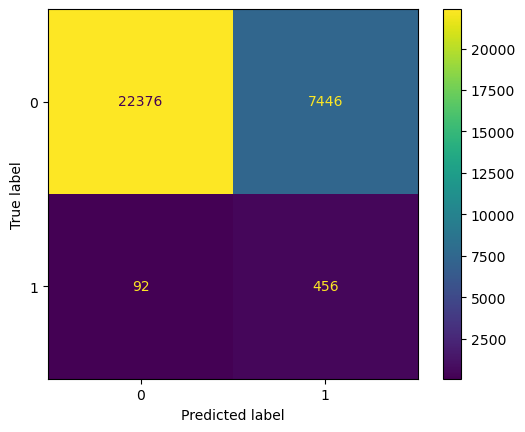

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     12781
           1       0.05      0.76      0.10       235

    accuracy                           0.75     13016
   macro avg       0.52      0.76      0.48     13016
weighted avg       0.98      0.75      0.84     13016

--------------------Confusion Matrix for test data: -------------------- 



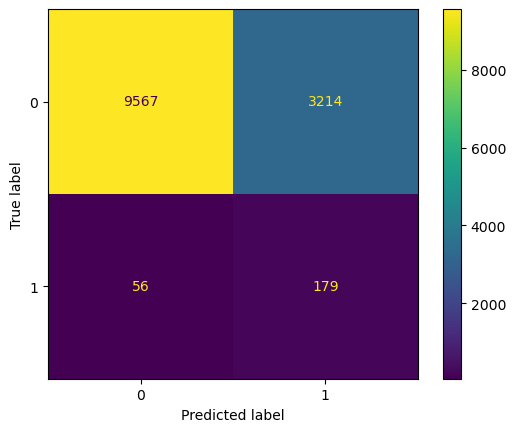

------------------------------ROC-AUC Curve------------------------------


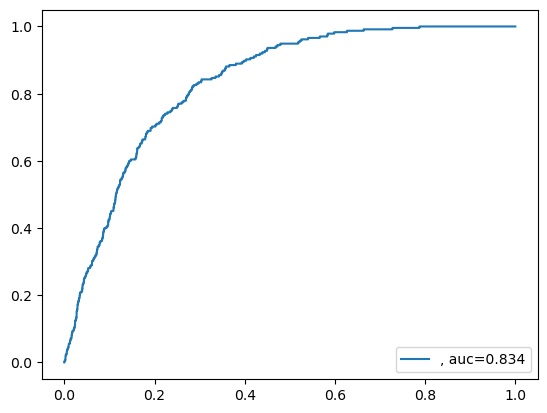

In [167]:
#ensemble model with xgboost as a based, layer with balancebaggingclassifer. 
params = {'estimator__n_estimators': list(range(100, 300, 10)),
           'estimator__learning_rate': list(np.linspace(0.01, 0.2, 5)),
           'estimator__max_depth': [2, 3, 4, 5, 6],
           'estimator__subsample': [0.5, 0.6, 0.7, 0.8],
           'estimator__colsample_bytree': list(np.linspace(0.1, 0.5, 5)),
           'estimator__gamma': [0, 1],
           'max_samples' : [0.1, 0.2, 0.3, 0.4, 0.5]
          }


model = BalancedBaggingClassifier(XGBClassifier(random_state = 0),n_estimators = 50)
rs_model = RandomizedSearchCV(model, param_distributions = params, n_iter = 200, \
                            scoring = custom_scorer, n_jobs = -1, error_score='raise')

rs_model = rs_model.fit(X_train, y_train)

print(rs_model.best_params_)
print(rs_model.best_score_)

model = rs_model.best_estimator_

evaluation(model, X_train, y_train, X_test, y_test)

In [168]:
#save BalancedBaggingClassifier + xgboost
bbc_xgboost_model = model

In [169]:
# bbc = BalancedBaggingClassifier(sampling_strategy='auto',\
#                                 replacement=False,random_state=0)
# # 'auto': means'not minority'--> resample all classes but the minority class

# bbc.fit(X_train, y_train)
# evaluation(bbc, X_train, y_train, X_test, y_test)

> BalancedRandomForestClassifier

0.816 +/- 0.060
--------------------Train data--------------------
--------------------Report for Train Data: --------------------
              precision    recall  f1-score   support

           0       1.00      0.73      0.85     29822
           1       0.06      1.00      0.12       548

    accuracy                           0.74     30370
   macro avg       0.53      0.87      0.48     30370
weighted avg       0.98      0.74      0.83     30370

Confusion Matrix for train data: 



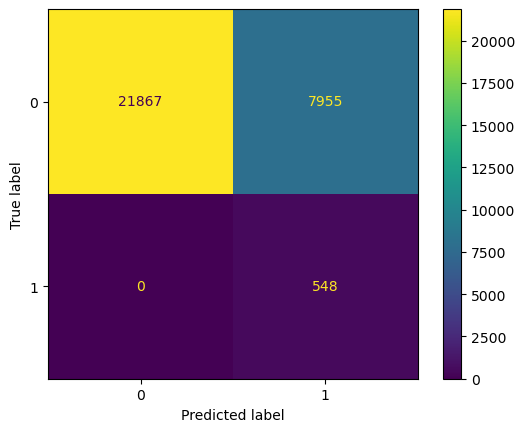

--------------------Test data--------------------
--------------------Report for Test Data: --------------------
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     12781
           1       0.05      0.79      0.10       235

    accuracy                           0.73     13016
   macro avg       0.52      0.76      0.47     13016
weighted avg       0.98      0.73      0.83     13016

--------------------Confusion Matrix for test data: -------------------- 



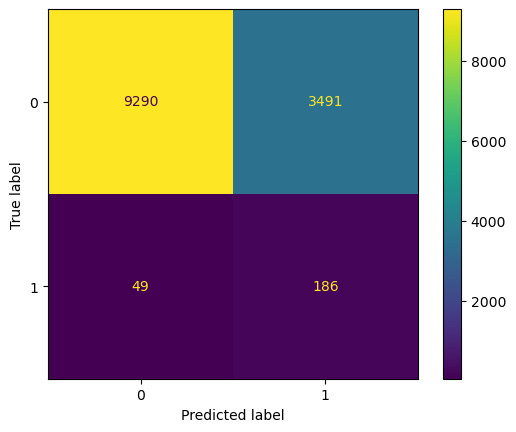

------------------------------ROC-AUC Curve------------------------------


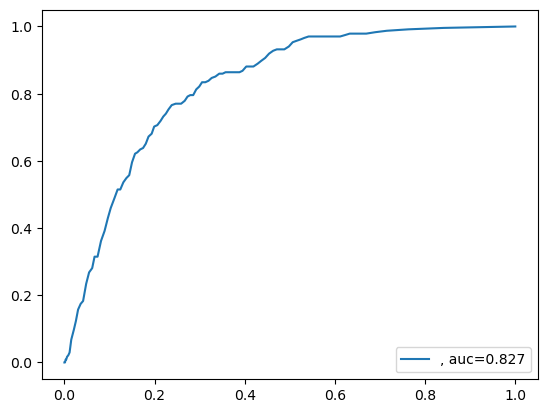

In [176]:
#cross-validation
from sklearn.model_selection import cross_validate
# Train the balanced random forest model
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf_model_cv = cross_validate(brf, X_train, y_train, cv = 10, n_jobs = -1, scoring=custom_scorer)
# Check the model performance
print(f"{brf_model_cv['test_score'].mean():.3f} +/- {brf_model_cv['test_score'].std():.3f}")
brf = brf.fit(X_train, y_train)
evaluation(brf, X_train, y_train, X_test, y_test)

In [177]:
brf_model_cv

{'fit_time': array([1.71837211, 1.71697807, 0.98266125, 1.74739099, 1.75022483,
        1.73305607, 1.70102882, 1.67909098, 1.71146703, 1.72963786]),
 'score_time': array([0.06566381, 0.06519079, 0.04776502, 0.05728102, 0.05465508,
        0.05689073, 0.05731034, 0.04903984, 0.04770279, 0.0481019 ]),
 'test_score': array([0.75925926, 0.85185185, 0.78181818, 0.87272727, 0.74545455,
        0.85454545, 0.87272727, 0.78181818, 0.90909091, 0.72727273])}